In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!pip install -q scikit-learn pandas numpy imbalanced-learn xgboost torch transformers
!pip install -q matplotlib seaborn nltk nlpaug wordcloud
!pip install -q datasets accelerate evaluate

# Import essential libraries
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import random
import os
from sklearn.utils import check_random_state
from google.colab import files
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
import re
import pickle
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.metrics import precision_recall_curve, roc_curve
import xgboost as xgb
from sklearn.ensemble import VotingClassifier, StackingClassifier
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from transformers import DataCollatorWithPadding
from torch.utils.data import Dataset
from sklearn.metrics import make_scorer, f1_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_curve, roc_curve, auc
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE

warnings.filterwarnings('ignore')

# Set plotting backend for Colab
%matplotlib inline

# Set random seeds for reproducibility (per research papers)
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_SEED)

# Check GPU availability
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Version: {torch.version.cuda}")

# Create directory structure
os.makedirs('/content/drive/MyDrive/Colab Notebooks/gh_hate_speech/data/processed', exist_ok=True)
os.makedirs('/content/drive/MyDrive/Colab Notebooks/gh_hate_speech/models', exist_ok=True)
os.makedirs('/content/drive/MyDrive/Colab Notebooks/gh_hate_speech/reports/figures', exist_ok=True)
os.makedirs('/content/drive/MyDrive/Colab Notebooks/gh_hate_speech/logs', exist_ok=True)

print("✅ Setup complete!")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.0 MB/s eta 0:00:00
Device: cuda
GPU: Tesla T4
CUDA Version: 12.6
✅ Setup complete!


In [5]:
# Download NLTK data
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)

def create_synthetic_data():
    """
    Create synthetic Nigerian Pidgin hate speech data based on examples from research papers
    Following patterns from NaijaHate, EkoHate, and VocalTweets papers
    """
    # Pidgin hate speech examples (research-based patterns)
    hate_examples = [
        "You be mumu, go die for gutter", "Wetin concern you? You no get sense",
        "All these yoruba people na thieves", "Igbo people too greedy, make them go",
        "This hausa man dey smell, abeg comot", "You dey craze? Go kill yourself",
        "Stupid fool, you no fit do anything", "All politicians na criminals and thieves",
        "These people too ugly, God punish them", "Make fire burn all of una",
        "You be goat, your family cursed", "Useless people, una go suffer tire",
        "All northerners na terrorists", "Southern people too proud, I hate them",
        "You dey mad? Go jump for well", "Foolish human being, die by fire",
        "All women na ashawo and useless", "Men too wicked, dem no get heart",
        "Christians na hypocrites, burn dem", "Muslims na extremists and killers",
        "Poor people smell, make dem go", "Rich people wicked, rob all of dem"
    ]

    # Non-hate examples (normal Pidgin conversation)
    non_hate_examples = [
        "Wetin dey happen? How you dey?", "Abeg help me with small money",
        "I dey go market, you wan follow?", "This food sweet well well",
        "Make we meet for evening", "I love this song, e dey sweet my ear",
        "God go bless you for this help", "Thank you for everything",
        "How your family dey? I hope say dem fine", "This weather too hot today",
        "I need to study for my exam", "Make we pray for peace in Nigeria",
        "Happy birthday, I wish you long life", "This movie funny well well",
        "I dey learn how to code", "Congratulations on your new job",
        "Please take care of yourself", "I appreciate your friendship",
        "Let us work together for better Nigeria", "Education na key to success",
        "God bless Nigeria and all citizens", "Peace and love to everyone"
    ]

    # Create balanced dataset (following NaijaHate 16% hate prevalence)
    data = []

    # Add hate examples
    for text in hate_examples:
        data.append({'text': text, 'label': 1})

    # Add more non-hate examples to create imbalance
    for text in non_hate_examples:
        data.append({'text': text, 'label': 0})

    # Add more non-hate to create realistic imbalance
    additional_non_hate = [
        f"Good morning, how your day dey go? {i}" for i in range(50)
    ] + [
        f"I dey appreciate your kindness {i}" for i in range(30)
    ] + [
        f"Make we continue to dey pray for our country {i}" for i in range(20)
    ]

    for text in additional_non_hate:
        data.append({'text': text, 'label': 0})

    df = pd.DataFrame(data)

    # Shuffle the data
    df = df.sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True)

    print(f"Synthetic dataset created: {len(df)} samples")
    print(f"Hate speech prevalence: {df['label'].mean():.2%}")

    return df

def load_or_create_data():
    """Load data from upload or create synthetic data"""
    try:
        # Try to load uploaded data
        print("Looking for uploaded data files...")
        train_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/gh_hate_speech/train.csv')
        val_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/gh_hate_speech/val.csv')
        test_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/gh_hate_speech/test.csv')
        print("✅ Data loaded from uploaded files")
        return train_df, val_df, test_df
    except FileNotFoundError:
        print("No uploaded data found. Creating synthetic data...")

        # Create synthetic data
        full_df = create_synthetic_data()

        # Split data (following NaijaHate 80/10/10 split)
        from sklearn.model_selection import train_test_split

        train_df, temp_df = train_test_split(
            full_df, test_size=0.2, random_state=RANDOM_SEED,
            stratify=full_df['label']
        )
        val_df, test_df = train_test_split(
            temp_df, test_size=0.5, random_state=RANDOM_SEED,
            stratify=temp_df['label']
        )

        # Save splits
        train_df.to_csv('/content/drive/MyDrive/Colab Notebooks/gh_hate_speech/data/processed/train.csv', index=False)
        val_df.to_csv('/content/drive/MyDrive/Colab Notebooks/gh_hate_speech/data/processed/val.csv', index=False)
        test_df.to_csv('/content/drive/MyDrive/Colab Notebooks/gh_hate_speech/data/processed/test.csv', index=False)

        print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

        return train_df, val_df, test_df

class PidginTextPreprocessor:
    """
    Text preprocessing for Nigerian Pidgin following research papers
    Based on EkoHate (Ilevbare et al.) and VocalTweets (Yusuf et al.)
    """

    def __init__(self):
        # Pidgin slang dictionary from research papers
        self.pidgin_dict = {
            'wetin': 'what', 'abeg': 'please', 'dey': 'is', 'no': 'not',
            'make': 'let', 'dem': 'them', 'una': 'you all', 'go': 'will',
            'fit': 'can', 'wan': 'want', 'comot': 'leave', 'tey': 'long time',
            'small': 'little', 'well': 'very', 'pikin': 'child', 'oga': 'boss',
            'madam': 'woman', 'chop': 'eat', 'gbege': 'problem', 'wahala': 'trouble',
            'kpakpando': 'star', 'omo': 'person', 'shey': 'is it', 'sha': 'just',
            'abi': 'right', 'nah': 'is', 'na': 'is', 'for': 'in', 'wey': 'that'
        }

        # Compile regex patterns
        self.url_pattern = re.compile(
            r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
        self.mention_pattern = re.compile(r'@[\w]+')
        self.hashtag_pattern = re.compile(r'#[\w]+')
        self.emoji_pattern = re.compile(
            r'[\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F1E0-\U0001F1FF]+')
        self.number_pattern = re.compile(r'\d+')

    def clean_text(self, text):
        """
        Clean text following VocalTweets regex-based cleaning approach
        """
        if pd.isna(text):
            return ""

        text = str(text).lower()

        # Remove URLs, mentions, hashtags (per VocalTweets)
        text = self.url_pattern.sub(' ', text)
        text = self.mention_pattern.sub(' ', text)
        text = self.hashtag_pattern.sub(' ', text)

        # Remove emojis and numbers
        text = self.emoji_pattern.sub(' ', text)
        text = self.number_pattern.sub(' ', text)

        # Normalize Pidgin slang (per EkoHate approach)
        words = text.split()
        normalized_words = []
        for word in words:
            if word in self.pidgin_dict:
                normalized_words.append(self.pidgin_dict[word])
            else:
                normalized_words.append(word)
        text = ' '.join(normalized_words)

        # Remove punctuation and extra spaces
        text = re.sub(r'[^\w\s]', ' ', text)
        text = ' '.join(text.split())

        return text

def preprocess_data(train_df, val_df, test_df):
    """
    Preprocess data following research paper methodologies
    """
    preprocessor = PidginTextPreprocessor()

    print("Preprocessing text data...")

    # Clean text
    train_df['text_clean'] = train_df['text'].apply(preprocessor.clean_text)
    val_df['text_clean'] = val_df['text'].apply(preprocessor.clean_text)
    test_df['text_clean'] = test_df['text'].apply(preprocessor.clean_text)

    # Remove empty texts
    train_df = train_df[train_df['text_clean'].str.len() > 0]
    val_df = val_df[val_df['text_clean'].str.len() > 0]
    test_df = test_df[test_df['text_clean'].str.len() > 0]

    # Calculate and save preprocessing statistics
    stats = {
        'original_train_size': len(train_df),
        'original_val_size': len(val_df),
        'original_test_size': len(test_df),
        'train_hate_prevalence': train_df['label'].mean(),
        'val_hate_prevalence': val_df['label'].mean(),
        'test_hate_prevalence': test_df['label'].mean(),
        'avg_text_length_train': train_df['text_clean'].str.len().mean(),
        'vocab_size_estimate': len(set(' '.join(train_df['text_clean']).split()))
    }

    with open('/content/drive/MyDrive/Colab Notebooks/gh_hate_speech/logs/preprocessing_stats.txt', 'w') as f:
        for key, value in stats.items():
            f.write(f"{key}: {value}\n")

    print("✅ Preprocessing complete!")
    print(f"Train hate prevalence: {stats['train_hate_prevalence']:.2%}")
    print(f"Estimated vocabulary size: {stats['vocab_size_estimate']}")

    return train_df, val_df, test_df

def handle_imbalance(X_train, y_train):
    """
    Handle class imbalance using SMOTE (per NaijaHate and AfriHate papers)
    """
    # Check if we need SMOTE (if hate < 20% as per papers)
    hate_prevalence = y_train.mean()

    if hate_prevalence < 0.20:
        print(f"Applying SMOTE (hate prevalence: {hate_prevalence:.2%})")

        smote = SMOTE(random_state=RANDOM_SEED, k_neighbors=3)
        X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

        print(f"After SMOTE: {len(X_resampled)} samples, hate: {y_resampled.mean():.2%}")
        return X_resampled, y_resampled
    else:
        print("No SMOTE needed (sufficient hate prevalence)")
        return X_train, y_train

def augment_minority_class(train_df):
    """
    Augment minority class using nlpaug (per VocalTweets approach)
    """
    try:
        import nlpaug.augmenter.word as naw

        # Only augment if we have severe imbalance
        hate_count = train_df[train_df['label'] == 1].shape[0]
        non_hate_count = train_df[train_df['label'] == 0].shape[0]

        if hate_count < non_hate_count * 0.3:  # If hate < 30% of non-hate
            print("Augmenting minority class...")

            aug = naw.SynonymAug(aug_src='wordnet')

            hate_texts = train_df[train_df['label'] == 1]['text_clean'].tolist()
            augmented_data = []

            for text in hate_texts[:10]:  # Augment first 10 samples
                try:
                    augmented_text = aug.augment(text)
                    if isinstance(augmented_text, list):
                        augmented_text = augmented_text[0]
                    augmented_data.append({'text_clean': augmented_text, 'label': 1})
                except:
                    continue

            if augmented_data:
                aug_df = pd.DataFrame(augmented_data)
                train_df = pd.concat([train_df, aug_df], ignore_index=True)
                print(f"Added {len(augmented_data)} augmented samples")

    except ImportError:
        print("nlpaug not available, skipping augmentation")

    return train_df

# Load and preprocess data
train_df, val_df, test_df = load_or_create_data()
train_df, val_df, test_df = preprocess_data(train_df, val_df, test_df)
train_df = augment_minority_class(train_df)

print(f"\nFinal dataset sizes:")
print(f"Train: {len(train_df)} (hate: {train_df['label'].mean():.2%})")
print(f"Val: {len(val_df)} (hate: {val_df['label'].mean():.2%})")
print(f"Test: {len(test_df)} (hate: {test_df['label'].mean():.2%})")


Looking for uploaded data files...
✅ Data loaded from uploaded files
Preprocessing text data...
✅ Preprocessing complete!
Train hate prevalence: 50.00%
Estimated vocabulary size: 27305

Final dataset sizes:
Train: 19926 (hate: 50.00%)
Val: 3346 (hate: 36.19%)
Test: 3347 (hate: 36.18%)


In [6]:
class FeatureEngineering:
    """
    Feature engineering following research paper approaches
    """

    def __init__(self):
        # TF-IDF parameters from NaijaHate (Osei et al., 2024)
        self.tfidf_vectorizer = TfidfVectorizer(
            ngram_range=(1, 2),  # Unigrams and bigrams
            max_features=5000,   # As per NaijaHate
            min_df=2,           # Minimum document frequency
            stop_words='english',
            lowercase=True,
            sublinear_tf=True
        )

        # BOW alternative
        self.bow_vectorizer = CountVectorizer(
            ngram_range=(1, 2),
            max_features=5000,
            min_df=2,
            stop_words='english',
            lowercase=True
        )

    def fit_transform_tfidf(self, train_texts, val_texts, test_texts):
        """
        Fit TF-IDF on training data and transform all sets
        """
        print("Fitting TF-IDF vectorizer...")

        X_train_tfidf = self.tfidf_vectorizer.fit_transform(train_texts)
        X_val_tfidf = self.tfidf_vectorizer.transform(val_texts)
        X_test_tfidf = self.tfidf_vectorizer.transform(test_texts)

        print(f"TF-IDF feature matrix shape: {X_train_tfidf.shape}")

        # Save vectorizer
        with open('/content/drive/MyDrive/Colab Notebooks/gh_hate_speech/models/tfidf_vectorizer.pkl', 'wb') as f:
            pickle.dump(self.tfidf_vectorizer, f)

        return X_train_tfidf, X_val_tfidf, X_test_tfidf

    def fit_transform_bow(self, train_texts, val_texts, test_texts):
        """
        Fit BOW on training data and transform all sets
        """
        print("Fitting BOW vectorizer...")

        X_train_bow = self.bow_vectorizer.fit_transform(train_texts)
        X_val_bow = self.bow_vectorizer.transform(val_texts)
        X_test_bow = self.bow_vectorizer.transform(test_texts)

        print(f"BOW feature matrix shape: {X_train_bow.shape}")

        # Save vectorizer
        with open('/content/drive/MyDrive/Colab Notebooks/gh_hate_speech/models/bow_vectorizer.pkl', 'wb') as f:
            pickle.dump(self.bow_vectorizer, f)

        return X_train_bow, X_val_bow, X_test_bow

# Create features
feature_eng = FeatureEngineering()

# TF-IDF features (primary approach from papers)
X_train_tfidf, X_val_tfidf, X_test_tfidf = feature_eng.fit_transform_tfidf(
    train_df['text_clean'], val_df['text_clean'], test_df['text_clean']
)

# BOW features (alternative)
X_train_bow, X_val_bow, X_test_bow = feature_eng.fit_transform_bow(
    train_df['text_clean'], val_df['text_clean'], test_df['text_clean']
)

# Labels
y_train = train_df['label'].values
y_val = val_df['label'].values
y_test = test_df['label'].values

print("✅ Feature engineering complete!")


Fitting TF-IDF vectorizer...
TF-IDF feature matrix shape: (19926, 5000)
Fitting BOW vectorizer...
BOW feature matrix shape: (19926, 5000)
✅ Feature engineering complete!


In [7]:
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV

class ClassicalModels:
    """
    Classical ML models following research paper configurations
    """

    def __init__(self):
        self.models = {}
        self.results = []

    def get_model_configs(self):
        """
        Get model configurations from research papers
        """
        configs = {
            # Logistic Regression (NaijaHate, EkoHate)
            'lr_baseline': LogisticRegression(random_state=RANDOM_SEED, max_iter=1000),
            'lr_balanced': LogisticRegression(random_state=RANDOM_SEED, max_iter=1000,
                                              class_weight='balanced'),
            'lr_tuned': LogisticRegression(random_state=RANDOM_SEED, max_iter=1000,
                                           C=1.0, class_weight='balanced'),

            # Naive Bayes (multiple papers)
            'nb_baseline': MultinomialNB(),
            'nb_balanced': MultinomialNB(alpha=0.1),
            'nb_tuned': MultinomialNB(alpha=0.01),

            # SVM (replaced with LinearSVC + calibration for probabilities)
            'svm_baseline': CalibratedClassifierCV(LinearSVC(random_state=RANDOM_SEED, max_iter=5000), cv=3),
            'svm_balanced': CalibratedClassifierCV(LinearSVC(random_state=RANDOM_SEED,
                                                             class_weight='balanced',
                                                             max_iter=5000), cv=3),
            'svm_tuned': CalibratedClassifierCV(LinearSVC(random_state=RANDOM_SEED,
                                                          C=1.0, class_weight='balanced',
                                                          max_iter=5000), cv=3),

            # Decision Tree
            'dt_baseline': DecisionTreeClassifier(random_state=RANDOM_SEED),
            'dt_balanced': DecisionTreeClassifier(random_state=RANDOM_SEED,
                                                  class_weight='balanced'),
            'dt_tuned': DecisionTreeClassifier(random_state=RANDOM_SEED,
                                               max_depth=10, class_weight='balanced'),

            # Random Forest (Eze et al.) with parallel training
            'rf_baseline': RandomForestClassifier(random_state=RANDOM_SEED, n_jobs=-1),
            'rf_balanced': RandomForestClassifier(random_state=RANDOM_SEED,
                                                  class_weight='balanced', n_jobs=-1),
            'rf_tuned': RandomForestClassifier(random_state=RANDOM_SEED,
                                               n_estimators=100, class_weight='balanced',
                                               n_jobs=-1),

            # XGBoost (EkoHate, VocalTweets - best performer) with parallel training
            'xgb_baseline': xgb.XGBClassifier(random_state=RANDOM_SEED, eval_metric='logloss',
                                              n_jobs=-1),
            'xgb_balanced': xgb.XGBClassifier(random_state=RANDOM_SEED, eval_metric='logloss',
                                              scale_pos_weight=len(y_train[y_train == 0]) /
                                                               len(y_train[y_train == 1]),
                                              n_jobs=-1),
            'xgb_tuned': xgb.XGBClassifier(random_state=RANDOM_SEED, eval_metric='logloss',
                                           n_estimators=100, max_depth=6,
                                           scale_pos_weight=len(y_train[y_train == 0]) /
                                                            len(y_train[y_train == 1]),
                                           n_jobs=-1)
        }

        return configs


    def train_model(self, model_name, model, X_train, y_train, X_val, y_val):
        """
        Train a single model
        """
        print(f"Training {model_name}...")

        # Train model
        model.fit(X_train, y_train)

        # Predictions
        y_pred = model.predict(X_val)
        y_pred_proba = model.predict_proba(X_val)[:, 1] if hasattr(model, 'predict_proba') else None

        # Metrics
        from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

        accuracy = accuracy_score(y_val, y_pred)
        precision = precision_score(y_val, y_pred, average='macro')
        recall = recall_score(y_val, y_pred, average='macro')
        f1 = f1_score(y_val, y_pred, average='macro')

        if y_pred_proba is not None:
            auc = roc_auc_score(y_val, y_pred_proba)
        else:
            auc = 0.0

        # Save model
        model_path = f'/content/drive/MyDrive/Colab Notebooks/gh_hate_speech/models/{model_name}.pkl'
        with open(model_path, 'wb') as f:
            pickle.dump(model, f)

        # Store results
        result = {
            'model_name': model_name,
            'accuracy': accuracy,
            'precision_macro': precision,
            'recall_macro': recall,
            'f1_macro': f1,
            'auc': auc
        }

        self.results.append(result)
        self.models[model_name] = model

        print(f"{model_name} - F1: {f1:.3f}, AUC: {auc:.3f}")

        return model

    def train_all_models(self, X_train, y_train, X_val, y_val, feature_type='tfidf'):
        """
        Train all classical models
        """
        configs = self.get_model_configs()

        for model_name, model in configs.items():
            try:
                self.train_model(f"{model_name}_{feature_type}", model,
                                 X_train, y_train, X_val, y_val)
            except Exception as e:
                print(f"Error training {model_name}: {e}")
                continue

    def get_results_df(self):
        """Get results as DataFrame"""
        return pd.DataFrame(self.results)

# Initialize classical models
classical_models = ClassicalModels()

# Handle imbalance for TF-IDF features
X_train_tfidf_balanced, y_train_balanced = handle_imbalance(X_train_tfidf, y_train)

print("Training classical models with TF-IDF features...")
classical_models.train_all_models(X_train_tfidf_balanced, y_train_balanced,
                                  X_val_tfidf, y_val, 'tfidf')

# Train with BOW features
print("\nTraining classical models with BOW features...")
X_train_bow_balanced, _ = handle_imbalance(X_train_bow, y_train)
classical_models.train_all_models(X_train_bow_balanced, y_train_balanced,
                                  X_val_bow, y_val, 'bow')

# Display results
results_df = classical_models.get_results_df()
print("\n=== CLASSICAL MODELS RESULTS ===")
print(results_df.sort_values('f1_macro', ascending=False))


No SMOTE needed (sufficient hate prevalence)
Training classical models with TF-IDF features...
Training lr_baseline_tfidf...
lr_baseline_tfidf - F1: 0.843, AUC: 0.903
Training lr_balanced_tfidf...
lr_balanced_tfidf - F1: 0.843, AUC: 0.903
Training lr_tuned_tfidf...
lr_tuned_tfidf - F1: 0.843, AUC: 0.903
Training nb_baseline_tfidf...
nb_baseline_tfidf - F1: 0.823, AUC: 0.888
Training nb_balanced_tfidf...
nb_balanced_tfidf - F1: 0.820, AUC: 0.883
Training nb_tuned_tfidf...
nb_tuned_tfidf - F1: 0.820, AUC: 0.880
Training svm_baseline_tfidf...
svm_baseline_tfidf - F1: 0.833, AUC: 0.898
Training svm_balanced_tfidf...
svm_balanced_tfidf - F1: 0.833, AUC: 0.898
Training svm_tuned_tfidf...
svm_tuned_tfidf - F1: 0.833, AUC: 0.898
Training dt_baseline_tfidf...
dt_baseline_tfidf - F1: 0.794, AUC: 0.795
Training dt_balanced_tfidf...
dt_balanced_tfidf - F1: 0.794, AUC: 0.795
Training dt_tuned_tfidf...
dt_tuned_tfidf - F1: 0.731, AUC: 0.812
Training rf_baseline_tfidf...
rf_baseline_tfidf - F1: 0.838

In [8]:
class FocalLoss(nn.Module):
    """
    Focal Loss for handling imbalance (per Tesfay et al., 2025)
    """
    def __init__(self, alpha=0.25, gamma=2.0):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        return focal_loss.mean()

class TextDataset(Dataset):
    """
    PyTorch Dataset for text classification
    """
    def __init__(self, sequences, labels):
        self.sequences = torch.tensor(sequences, dtype=torch.long)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]

class LSTMModel(nn.Module):
    """
    LSTM model (per AfriHate paper)
    """
    def __init__(self, vocab_size, embedding_dim=100, hidden_dim=64, num_classes=2, dropout=0.3):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, dropout=dropout)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, (hidden, _) = self.lstm(embedded)
        # Use the last hidden state
        output = self.dropout(hidden[-1])
        output = self.fc(output)
        return output

class BiLSTMModel(nn.Module):
    """
    Bidirectional LSTM model (per Tesfay et al.)
    """
    def __init__(self, vocab_size, embedding_dim=100, hidden_dim=64, num_classes=2, dropout=0.3):
        super(BiLSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.bilstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True,
                              bidirectional=True, dropout=dropout)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 2, num_classes)

    def forward(self, x):
        embedded = self.embedding(x)
        bilstm_out, (hidden, _) = self.bilstm(embedded)
        # Concatenate forward and backward hidden states
        output = torch.cat((hidden[-2], hidden[-1]), dim=1)
        output = self.dropout(output)
        output = self.fc(output)
        return output

class CNNModel(nn.Module):
    """
    CNN model (per AfriHate paper)
    """
    def __init__(self, vocab_size, embedding_dim=100, num_filters=128, filter_sizes=[3, 4, 5],
                 num_classes=2, dropout=0.5):
        super(CNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.convs = nn.ModuleList([
            nn.Conv1d(embedding_dim, num_filters, kernel_size=fs)
            for fs in filter_sizes
        ])
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(len(filter_sizes) * num_filters, num_classes)

    def forward(self, x):
        embedded = self.embedding(x).transpose(1, 2)  # (batch, embedding_dim, seq_len)
        conv_outputs = []
        for conv in self.convs:
            conv_out = F.relu(conv(embedded))
            pooled = F.max_pool1d(conv_out, conv_out.size(2)).squeeze(2)
            conv_outputs.append(pooled)

        concat_output = torch.cat(conv_outputs, dim=1)
        output = self.dropout(concat_output)
        output = self.fc(output)
        return output

class HybridCNNBiLSTM(nn.Module):
    """
    Hybrid CNN-BiLSTM model (per AfriHate)
    """
    def __init__(self, vocab_size, embedding_dim=100, hidden_dim=64, num_filters=64,
                 num_classes=2, dropout=0.3):
        super(HybridCNNBiLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # CNN branch
        self.conv1 = nn.Conv1d(embedding_dim, num_filters, kernel_size=3)
        self.conv2 = nn.Conv1d(num_filters, num_filters, kernel_size=3)

        # BiLSTM branch
        self.bilstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True,
                              bidirectional=True, dropout=dropout)

        self.dropout = nn.Dropout(dropout)
        # Combine CNN and BiLSTM outputs
        self.fc = nn.Linear(num_filters + hidden_dim * 2, num_classes)

    def forward(self, x):
        embedded = self.embedding(x)

        # CNN branch
        cnn_input = embedded.transpose(1, 2)  # (batch, embedding_dim, seq_len)
        cnn_out = F.relu(self.conv1(cnn_input))
        cnn_out = F.max_pool1d(cnn_out, 2)
        cnn_out = F.relu(self.conv2(cnn_out))
        cnn_out = F.adaptive_max_pool1d(cnn_out, 1).squeeze(2)

        # BiLSTM branch
        bilstm_out, (hidden, _) = self.bilstm(embedded)
        bilstm_out = torch.cat((hidden[-2], hidden[-1]), dim=1)

        # Combine
        combined = torch.cat((cnn_out, bilstm_out), dim=1)
        output = self.dropout(combined)
        output = self.fc(output)
        return output

class PyTorchModels:
    """
    PyTorch Deep Learning models
    """
    def __init__(self, vocab_size=5000, max_length=128):
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.models = {}
        self.results = []
        self.device = device

        # Create tokenizer
        self.word_to_idx = {'<PAD>': 0, '<UNK>': 1}
        self.idx_to_word = {0: '<PAD>', 1: '<UNK>'}

    def build_vocab(self, texts):
        """Build vocabulary from texts"""
        print("Building vocabulary...")
        word_counts = Counter()
        for text in texts:
            words = text.split()
            word_counts.update(words)

        # Add most frequent words to vocabulary
        most_common = word_counts.most_common(self.vocab_size - 2)
        for i, (word, count) in enumerate(most_common):
            idx = i + 2
            self.word_to_idx[word] = idx
            self.idx_to_word[idx] = word

        print(f"Vocabulary size: {len(self.word_to_idx)}")

    def texts_to_sequences(self, texts):
        """Convert texts to sequences of integers"""
        sequences = []
        for text in texts:
            words = text.split()
            sequence = [self.word_to_idx.get(word, 1) for word in words]  # 1 is <UNK>
            # Pad or truncate
            if len(sequence) < self.max_length:
                sequence.extend([0] * (self.max_length - len(sequence)))  # 0 is <PAD>
            else:
                sequence = sequence[:self.max_length]
            sequences.append(sequence)
        return np.array(sequences)

    def prepare_data(self, train_texts, val_texts, test_texts, y_train, y_val, y_test):
        """Prepare data for PyTorch models"""
        print("Preparing data for PyTorch models...")

        # Build vocabulary on training data
        self.build_vocab(train_texts)

        # Convert texts to sequences
        X_train_seq = self.texts_to_sequences(train_texts)
        X_val_seq = self.texts_to_sequences(val_texts)
        X_test_seq = self.texts_to_sequences(test_texts)

        # Create datasets
        train_dataset = TextDataset(X_train_seq, y_train)
        val_dataset = TextDataset(X_val_seq, y_val)
        test_dataset = TextDataset(X_test_seq, y_test)

        return train_dataset, val_dataset, test_dataset

    def train_model(self, model_name, model, train_dataset, val_dataset, loss_fn, epochs=10):
        """Train a PyTorch model"""
        print(f"Training {model_name}...")

        model = model.to(self.device)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

        best_val_f1 = 0
        best_model_state = None

        for epoch in range(epochs):
            # Training
            model.train()
            train_loss = 0
            for batch_x, batch_y in train_loader:
                batch_x, batch_y = batch_x.to(self.device), batch_y.to(self.device)

                optimizer.zero_grad()
                outputs = model(batch_x)
                loss = loss_fn(outputs, batch_y)
                loss.backward()
                optimizer.step()

                train_loss += loss.item()

            # Validation
            model.eval()
            val_predictions = []
            val_probabilities = []
            val_true = []

            with torch.no_grad():
                for batch_x, batch_y in val_loader:
                    batch_x, batch_y = batch_x.to(self.device), batch_y.to(self.device)
                    outputs = model(batch_x)
                    probabilities = F.softmax(outputs, dim=1)
                    predictions = torch.argmax(outputs, dim=1)

                    val_predictions.extend(predictions.cpu().numpy())
                    val_probabilities.extend(probabilities[:, 1].cpu().numpy())
                    val_true.extend(batch_y.cpu().numpy())

            # Calculate metrics
            from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

            val_f1 = f1_score(val_true, val_predictions, average='macro')
            val_acc = accuracy_score(val_true, val_predictions)

            if val_f1 > best_val_f1:
                best_val_f1 = val_f1
                best_model_state = model.state_dict().copy()

            print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss/len(train_loader):.4f}, "
                  f"Val F1: {val_f1:.4f}, Val Acc: {val_acc:.4f}")

        # Load best model
        model.load_state_dict(best_model_state)

        # Final evaluation
        model.eval()
        val_predictions = []
        val_probabilities = []
        val_true = []

        with torch.no_grad():
            for batch_x, batch_y in val_loader:
                batch_x, batch_y = batch_x.to(self.device), batch_y.to(self.device)
                outputs = model(batch_x)
                probabilities = F.softmax(outputs, dim=1)
                predictions = torch.argmax(outputs, dim=1)

                val_predictions.extend(predictions.cpu().numpy())
                val_probabilities.extend(probabilities[:, 1].cpu().numpy())
                val_true.extend(batch_y.cpu().numpy())

        # Calculate final metrics
        accuracy = accuracy_score(val_true, val_predictions)
        precision = precision_score(val_true, val_predictions, average='macro')
        recall = recall_score(val_true, val_predictions, average='macro')
        f1 = f1_score(val_true, val_predictions, average='macro')
        auc = roc_auc_score(val_true, val_probabilities)

        # Save model
        model_path = f'/content/drive/MyDrive/Colab Notebooks/gh_hate_speech/models/{model_name}.pt'
        torch.save(model.state_dict(), model_path)

        # Store results
        result = {
            'model_name': model_name,
            'accuracy': accuracy,
            'precision_macro': precision,
            'recall_macro': recall,
            'f1_macro': f1,
            'auc': auc
        }

        self.results.append(result)
        self.models[model_name] = model

        print(f"{model_name} - F1: {f1:.3f}, AUC: {auc:.3f}")

        return model

    def train_all_models(self, train_dataset, val_dataset):
        """Train all PyTorch models"""
        models_to_train = [
            ('lstm_base', LSTMModel(self.vocab_size), nn.CrossEntropyLoss()),
            ('lstm_focal', LSTMModel(self.vocab_size), FocalLoss()),
            ('bilstm_base', BiLSTMModel(self.vocab_size), nn.CrossEntropyLoss()),
            ('bilstm_focal', BiLSTMModel(self.vocab_size), FocalLoss()),
            ('cnn_base', CNNModel(self.vocab_size), nn.CrossEntropyLoss()),
            ('cnn_focal', CNNModel(self.vocab_size), FocalLoss()),
            ('hybrid_cnn_bilstm', HybridCNNBiLSTM(self.vocab_size), nn.CrossEntropyLoss())
        ]

        for model_name, model, loss_fn in models_to_train:
            try:
                self.train_model(model_name, model, train_dataset, val_dataset, loss_fn, epochs=5)
            except Exception as e:
                print(f"Error training {model_name}: {e}")
                continue

    def get_results_df(self):
        """Get results as DataFrame"""
        return pd.DataFrame(self.results)

# Initialize PyTorch models
pytorch_models = PyTorchModels()

# Prepare data for PyTorch
train_dataset, val_dataset, test_dataset = pytorch_models.prepare_data(
    train_df['text_clean'].tolist(), val_df['text_clean'].tolist(), test_df['text_clean'].tolist(),
    y_train, y_val, y_test
)

print("Training PyTorch deep learning models...")
pytorch_models.train_all_models(train_dataset, val_dataset)

# Display results
pytorch_results_df = pytorch_models.get_results_df()
print("\n=== PYTORCH DEEP LEARNING MODELS RESULTS ===")
print(pytorch_results_df.sort_values('f1_macro', ascending=False))


Preparing data for PyTorch models...
Building vocabulary...
Vocabulary size: 5000
Training PyTorch deep learning models...
Training lstm_base...
Epoch 1/5, Train Loss: 0.6946, Val F1: 0.2657, Val Acc: 0.3619
Epoch 2/5, Train Loss: 0.6936, Val F1: 0.2657, Val Acc: 0.3619
Epoch 3/5, Train Loss: 0.6934, Val F1: 0.2657, Val Acc: 0.3619
Epoch 4/5, Train Loss: 0.6933, Val F1: 0.2657, Val Acc: 0.3619
Epoch 5/5, Train Loss: 0.6933, Val F1: 0.2657, Val Acc: 0.3619
lstm_base - F1: 0.266, AUC: 0.500
Training lstm_focal...
Epoch 1/5, Train Loss: 0.0435, Val F1: 0.2657, Val Acc: 0.3619
Epoch 2/5, Train Loss: 0.0433, Val F1: 0.3895, Val Acc: 0.6381
Epoch 3/5, Train Loss: 0.0433, Val F1: 0.3895, Val Acc: 0.6381
Epoch 4/5, Train Loss: 0.0433, Val F1: 0.2657, Val Acc: 0.3619
Epoch 5/5, Train Loss: 0.0433, Val F1: 0.3895, Val Acc: 0.6381
lstm_focal - F1: 0.390, AUC: 0.500
Training bilstm_base...
Epoch 1/5, Train Loss: 0.4430, Val F1: 0.8297, Val Acc: 0.8446
Epoch 2/5, Train Loss: 0.3075, Val F1: 0.8404,

In [9]:
class HateSpeechDataset(Dataset):
    """
    Dataset class for transformer training
    """
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

class TransformerModels:
    """
    Transformer models following research papers
    """
    def __init__(self):
        self.models = {}
        self.results = []
        self.device = device

    def get_model_checkpoint(self, model_name):
        """
        Map model names to their HuggingFace identifiers
        """
        model_mapping = {
            'twitter_roberta': 'cardiffnlp/twitter-roberta-base-sentiment-latest',
            'naijaxlm_t': 'Davlan/naija-twitter-sentiment-afriberta',  # Alternative since exact model may not be available
            'afroxlmr': 'Davlan/afro-xlmr-base',  # Alternative African multilingual model
            'bertweet': 'vinai/bertweet-base',
            'xlm_roberta_base': 'xlm-roberta-base',
            'afriberta_base': 'Davlan/afriberta_base',  # Correct AfriLM model
        }
        return model_mapping.get(model_name, 'xlm-roberta-base')

    def train_transformer(self, model_name, X_train, y_train, X_val, y_val):
        """
        Train transformer model
        """
        print(f"Training {model_name}...")

        model_checkpoint = self.get_model_checkpoint(model_name)

        try:
            # Load tokenizer and model
            tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
            model = AutoModelForSequenceClassification.from_pretrained(
                model_checkpoint,
                num_labels=2,
                problem_type="single_label_classification",
                ignore_mismatched_sizes=True  # Handle classifier head mismatch
            )

            # Move model to device
            model = model.to(self.device)

            # Create datasets
            train_dataset = HateSpeechDataset(X_train, y_train, tokenizer)
            val_dataset = HateSpeechDataset(X_val, y_val, tokenizer)

            # Training arguments (fixed deprecated parameter)
            training_args = TrainingArguments(
                output_dir=f'/content/drive/MyDrive/Colab Notebooks/gh_hate_speech/models/{model_name}',
                num_train_epochs=3,
                per_device_train_batch_size=16,
                per_device_eval_batch_size=16,
                learning_rate=2e-5,
                warmup_steps=500,
                weight_decay=0.01,
                logging_dir=f'/content/drive/MyDrive/Colab Notebooks/gh_hate_speech/logs/{model_name}',
                logging_steps=10,
                eval_strategy="epoch",  # Fixed: was 'evaluation_strategy'
                save_strategy="epoch",
                load_best_model_at_end=True,
                metric_for_best_model="eval_f1",
                greater_is_better=True,
                seed=RANDOM_SEED,
                remove_unused_columns=False,
                dataloader_pin_memory=False,  # Helps with memory issues
                report_to=[]  # Disable wandb logging
            )

            # Data collator
            data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

            # Metrics function
            def compute_metrics(eval_pred):
                predictions, labels = eval_pred
                predictions = np.argmax(predictions, axis=1)

                from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score

                accuracy = accuracy_score(labels, predictions)
                precision, recall, f1, _ = precision_recall_fscore_support(
                    labels, predictions, average='macro', zero_division=0
                )

                # Calculate AUC if possible
                try:
                    # Get probabilities for AUC calculation
                    probs = torch.softmax(torch.tensor(eval_pred[0]), dim=1)[:, 1].numpy()
                    auc = roc_auc_score(labels, probs)
                except:
                    auc = 0.0

                return {
                    'accuracy': accuracy,
                    'f1': f1,
                    'precision': precision,
                    'recall': recall,
                    'auc': auc
                }

            # Trainer
            trainer = Trainer(
                model=model,
                args=training_args,
                train_dataset=train_dataset,
                eval_dataset=val_dataset,
                tokenizer=tokenizer,
                data_collator=data_collator,
                compute_metrics=compute_metrics
            )

            # Train with error handling
            try:
                trainer.train()
            except RuntimeError as e:
                if "out of memory" in str(e).lower():
                    print(f"GPU out of memory for {model_name}. Reducing batch size...")
                    # Reduce batch size and try again
                    training_args.per_device_train_batch_size = 8
                    training_args.per_device_eval_batch_size = 8
                    trainer.args = training_args
                    trainer.train()
                else:
                    raise e

            # Evaluate
            eval_results = trainer.evaluate()

            # Create directories if they don't exist
            import os
            os.makedirs(f'/content/drive/MyDrive/Colab Notebooks/gh_hate_speech/models/{model_name}', exist_ok=True)

            # Save model
            trainer.save_model(f'/content/drive/MyDrive/Colab Notebooks/gh_hate_speech/models/{model_name}')
            tokenizer.save_pretrained(f'/content/drive/MyDrive/Colab Notebooks/gh_hate_speech/models/{model_name}')

            # Store results with consistent naming
            result = {
                'model_name': model_name,
                'accuracy': eval_results['eval_accuracy'],
                'precision_macro': eval_results['eval_precision'],
                'recall_macro': eval_results['eval_recall'],
                'f1_macro': eval_results['eval_f1'],
                'auc': eval_results.get('eval_auc', 0.0)
            }

            self.results.append(result)
            self.models[model_name] = trainer

            print(f"{model_name} - F1: {eval_results['eval_f1']:.3f}, Accuracy: {eval_results['eval_accuracy']:.3f}")

            return trainer

        except Exception as e:
            print(f"Error training {model_name}: {e}")
            # Still add a placeholder result to avoid empty DataFrame
            placeholder_result = {
                'model_name': model_name,
                'accuracy': 0.0,
                'precision_macro': 0.0,
                'recall_macro': 0.0,
                'f1_macro': 0.0,
                'auc': 0.0,
                'status': 'failed'
            }
            self.results.append(placeholder_result)
            return None

    def train_all_transformers(self, X_train, y_train, X_val, y_val):
        """
        Train all transformer models including the requested ones
        """
        models_to_train = [
            'twitter_roberta',      # Twitter-RoBERTa-base
            'naijaxlm_t',          # NAIJAXLM-T (using alternative)
            'afroxlmr',            # AfroXLMR (using alternative)
            'bertweet',            # BERTweet
            'xlm_roberta_base',    # XLM-RoBERTa-base
            'afriberta_base'       # AfriLM/AfriCLM (corrected model)
        ]

        for model_name in models_to_train:
            try:
                print(f"\n{'='*50}")
                print(f"Starting training for: {model_name}")
                print(f"{'='*50}")
                self.train_transformer(model_name, X_train, y_train, X_val, y_val)
            except Exception as e:
                print(f"Skipping {model_name} due to error: {e}")
                continue

    def get_results_df(self):
        """Get results as DataFrame"""
        if not self.results:
            # Return empty DataFrame with correct columns if no results
            return pd.DataFrame(columns=['model_name', 'accuracy', 'precision_macro', 'recall_macro', 'f1_macro', 'auc'])
        return pd.DataFrame(self.results)

# Training execution with improved error handling
if device == 'cuda':
    print("Training transformer models (GPU available)...")
    transformer_models = TransformerModels()

    # Convert to lists for transformer training
    X_train_texts = train_df['text_clean'].tolist()
    X_val_texts = val_df['text_clean'].tolist()

    # Train models
    transformer_models.train_all_transformers(X_train_texts, y_train, X_val_texts, y_val)

    # Display results with error handling
    transformer_results_df = transformer_models.get_results_df()
    print("\n" + "="*60)
    print("TRANSFORMER MODELS RESULTS")
    print("="*60)

    if not transformer_results_df.empty and 'f1_macro' in transformer_results_df.columns:
        # Sort by F1 score, excluding failed models
        successful_results = transformer_results_df[transformer_results_df['f1_macro'] > 0]
        if not successful_results.empty:
            print("\nSuccessful Models (sorted by F1 score):")
            print(successful_results.sort_values('f1_macro', ascending=False).round(4))

        # Show failed models
        failed_results = transformer_results_df[transformer_results_df['f1_macro'] == 0]
        if not failed_results.empty:
            print(f"\nFailed Models ({len(failed_results)}):")
            print(failed_results[['model_name', 'status']].to_string(index=False))
    else:
        print("No successful model training results to display.")
        print(transformer_results_df)

else:
    print("GPU not available, skipping transformer models")
    transformer_results_df = pd.DataFrame()
    transformer_models = TransformerModels()

# Optional: Display model information
print("\n" + "="*60)
print("MODEL INFORMATION")
print("="*60)
model_info = {
    'twitter_roberta': 'Twitter-RoBERTa-base: Social media pre-trained',
    'naijaxlm_t': 'NAIJAXLM-T: Nigerian Twitter domain adapted',
    'afroxlmr': 'AfroXLMR: Multilingual African focus',
    'bertweet': 'BERTweet: Twitter-specific pre-training',
    'xlm_roberta_base': 'XLM-RoBERTa: Cross-lingual baseline',
    'afriberta_base': 'AfriLM: African languages focus'
}

for model, description in model_info.items():
    print(f"{model:20}: {description}")

Training transformer models (GPU available)...

Starting training for: twitter_roberta
Training twitter_roberta...


config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([3, 768]) in the checkpo

model.safetensors:   0%|          | 0.00/501M [00:00<?, ?B/s]

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Auc
1,0.191800,0.411659,0.854154,0.841542,0.842831,0.840327,0.915743
2,0.237500,0.385808,0.859235,0.848698,0.846426,0.851277,0.922984
3,0.132700,0.484944,0.851763,0.842044,0.837733,0.847924,0.918209


twitter_roberta - F1: 0.849, Accuracy: 0.859

Starting training for: naijaxlm_t
Training naijaxlm_t...
Error training naijaxlm_t: Davlan/naija-twitter-sentiment-afriberta is not a local folder and is not a valid model identifier listed on 'https://huggingface.co/models'
If this is a private repository, make sure to pass a token having permission to this repo either by logging in with `hf auth login` or by passing `token=<your_token>`

Starting training for: afroxlmr
Training afroxlmr...


tokenizer_config.json:   0%|          | 0.00/398 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/707 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at Davlan/afro-xlmr-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Auc
1,0.218600,0.389499,0.854154,0.841944,0.842317,0.841578,0.910689
2,0.261100,0.355350,0.862821,0.851470,0.851533,0.851407,0.920536
3,0.200800,0.401177,0.852959,0.842454,0.839376,0.846181,0.920298


afroxlmr - F1: 0.851, Accuracy: 0.863

Starting training for: bertweet
Training bertweet...


config.json:   0%|          | 0.00/558 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

bpe.codes: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


pytorch_model.bin:   0%|          | 0.00/543M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/543M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Auc
1,0.218000,0.386469,0.854154,0.839724,0.845706,0.834966,0.910349
2,0.262900,0.355691,0.862821,0.851629,0.851319,0.851943,0.921286
3,0.185400,0.442434,0.838912,0.829730,0.824416,0.838747,0.919332


bertweet - F1: 0.852, Accuracy: 0.863

Starting training for: xlm_roberta_base
Training xlm_roberta_base...


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Auc
1,0.254000,0.408845,0.845188,0.835245,0.830794,0.841521,0.903774
2,0.299200,0.394938,0.842499,0.832617,0.827966,0.839413,0.912479


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Auc
1,0.254000,0.408845,0.845188,0.835245,0.830794,0.841521,0.903774
2,0.299200,0.394938,0.842499,0.832617,0.827966,0.839413,0.912479
3,0.245300,0.425816,0.841602,0.832549,0.827195,0.841570,0.911868


xlm_roberta_base - F1: 0.835, Accuracy: 0.845

Starting training for: afriberta_base
Training afriberta_base...
Error training afriberta_base: Davlan/afriberta_base is not a local folder and is not a valid model identifier listed on 'https://huggingface.co/models'
If this is a private repository, make sure to pass a token having permission to this repo either by logging in with `hf auth login` or by passing `token=<your_token>`

TRANSFORMER MODELS RESULTS

Successful Models (sorted by F1 score):
         model_name  accuracy  precision_macro  recall_macro  f1_macro  \
3          bertweet    0.8628           0.8513        0.8519    0.8516   
2          afroxlmr    0.8628           0.8515        0.8514    0.8515   
0   twitter_roberta    0.8592           0.8464        0.8513    0.8487   
4  xlm_roberta_base    0.8452           0.8308        0.8415    0.8352   

      auc status  
3  0.9213    NaN  
2  0.9205    NaN  
0  0.9230    NaN  
4  0.9038    NaN  

Failed Models (2):
    model_nam

In [11]:
class HateSpeechDataset(Dataset):
    """
    Dataset class for transformer training
    """
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

class TransformerModels:
    """
    Top 5 Transformer models for hate speech detection
    """
    def __init__(self):
        self.models = {}
        self.results = []
        self.device = device

    def get_model_checkpoint(self, model_name):
        """
        Map model names to their verified HuggingFace identifiers
        Top 3 High-Performance + Top 2 African-Based Models
        """
        model_mapping = {
            # Top 3 High-Performance Models
            'electra_base': 'google/electra-base-discriminator',        # F1: 0.8980 (top performer)
            'hate_bert': 'unitary/toxic-bert',                          # Specialized hate detection
            'deberta_v3': 'microsoft/deberta-v3-base',                  # Enhanced attention mechanisms

           'afro_xlmr_small': 'Davlan/afro-xlmr-small',              # Small African languages model (~100M parameters)
            'distil_bertweet': 'vinai/bertweet-base' # African Twitter sentiment
        }
        return model_mapping.get(model_name, 'xlm-roberta-base')

    def train_transformer(self, model_name, X_train, y_train, X_val, y_val):
        """
        Train transformer model
        """
        print(f"Training {model_name}...")

        model_checkpoint = self.get_model_checkpoint(model_name)

        try:
            # Load tokenizer and model
            tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
            model = AutoModelForSequenceClassification.from_pretrained(
                model_checkpoint,
                num_labels=2,
                problem_type="single_label_classification",
                ignore_mismatched_sizes=True  # Handle classifier head mismatch
            )

            # Move model to device
            model = model.to(self.device)

            # Create datasets
            train_dataset = HateSpeechDataset(X_train, y_train, tokenizer)
            val_dataset = HateSpeechDataset(X_val, y_val, tokenizer)

            # Training arguments optimized for top performance
            training_args = TrainingArguments(
                output_dir=f'/content/drive/MyDrive/Colab Notebooks/gh_hate_speech/models/{model_name}',
                num_train_epochs=3,
                per_device_train_batch_size=16,
                per_device_eval_batch_size=16,
                learning_rate=2e-5,
                warmup_steps=500,
                weight_decay=0.01,
                logging_dir=f'/content/drive/MyDrive/Colab Notebooks/gh_hate_speech/logs/{model_name}',
                logging_steps=10,
                eval_strategy="epoch",
                save_strategy="epoch",
                load_best_model_at_end=True,
                metric_for_best_model="eval_f1",
                greater_is_better=True,
                seed=RANDOM_SEED,
                remove_unused_columns=False,
                dataloader_pin_memory=False,  # Helps with memory issues
                report_to=[],  # Disable wandb logging
                fp16=True if device == 'cuda' else False,  # Mixed precision for efficiency
                gradient_accumulation_steps=2,  # Help with memory
                dataloader_num_workers=0  # Avoid multiprocessing issues
            )

            # Data collator
            data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

            # Enhanced metrics function
            def compute_metrics(eval_pred):
                predictions, labels = eval_pred
                predictions = np.argmax(predictions, axis=1)

                from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score

                accuracy = accuracy_score(labels, predictions)
                precision, recall, f1, _ = precision_recall_fscore_support(
                    labels, predictions, average='macro', zero_division=0
                )

                # Also compute weighted metrics for imbalanced datasets
                precision_w, recall_w, f1_w, _ = precision_recall_fscore_support(
                    labels, predictions, average='weighted', zero_division=0
                )

                # Calculate AUC if possible
                try:
                    # Get probabilities for AUC calculation
                    probs = torch.softmax(torch.tensor(eval_pred[0]), dim=1)[:, 1].numpy()
                    auc = roc_auc_score(labels, probs)
                except:
                    auc = 0.0

                return {
                    'accuracy': accuracy,
                    'f1': f1,
                    'f1_weighted': f1_w,
                    'precision': precision,
                    'precision_weighted': precision_w,
                    'recall': recall,
                    'recall_weighted': recall_w,
                    'auc': auc
                }

            # Trainer
            trainer = Trainer(
                model=model,
                args=training_args,
                train_dataset=train_dataset,
                eval_dataset=val_dataset,
                tokenizer=tokenizer,
                data_collator=data_collator,
                compute_metrics=compute_metrics
            )

            # Train with progressive error handling
            try:
                trainer.train()
            except RuntimeError as e:
                if "out of memory" in str(e).lower():
                    print(f"GPU out of memory for {model_name}. Reducing batch size...")
                    # Progressive batch size reduction
                    for batch_size in [8, 4, 2]:
                        try:
                            training_args.per_device_train_batch_size = batch_size
                            training_args.per_device_eval_batch_size = batch_size
                            training_args.gradient_accumulation_steps = max(1, 16 // batch_size)
                            trainer = Trainer(
                                model=model,
                                args=training_args,
                                train_dataset=train_dataset,
                                eval_dataset=val_dataset,
                                tokenizer=tokenizer,
                                data_collator=data_collator,
                                compute_metrics=compute_metrics
                            )
                            trainer.train()
                            break
                        except RuntimeError as inner_e:
                            if "out of memory" in str(inner_e).lower() and batch_size > 2:
                                continue
                            else:
                                raise inner_e
                else:
                    raise e

            # Evaluate
            eval_results = trainer.evaluate()

            # Create directories if they don't exist
            import os
            os.makedirs(f'/content/drive/MyDrive/Colab Notebooks/gh_hate_speech/models/{model_name}', exist_ok=True)

            # Save model
            trainer.save_model(f'/content/drive/MyDrive/Colab Notebooks/gh_hate_speech/models/{model_name}')
            tokenizer.save_pretrained(f'/content/drive/MyDrive/Colab Notebooks/gh_hate_speech/models/{model_name}')

            # Store results with enhanced metrics
            result = {
                'model_name': model_name,
                'model_checkpoint': model_checkpoint,
                'accuracy': eval_results['eval_accuracy'],
                'precision_macro': eval_results['eval_precision'],
                'precision_weighted': eval_results['eval_precision_weighted'],
                'recall_macro': eval_results['eval_recall'],
                'recall_weighted': eval_results['eval_recall_weighted'],
                'f1_macro': eval_results['eval_f1'],
                'f1_weighted': eval_results['eval_f1_weighted'],
                'auc': eval_results.get('eval_auc', 0.0),
                'status': 'success'
            }

            self.results.append(result)
            self.models[model_name] = trainer

            print(f"{model_name} - F1 Macro: {eval_results['eval_f1']:.3f}, F1 Weighted: {eval_results['eval_f1_weighted']:.3f}, Accuracy: {eval_results['eval_accuracy']:.3f}")

            # Clean up GPU memory
            del model
            torch.cuda.empty_cache() if torch.cuda.is_available() else None

            return trainer

        except Exception as e:
            print(f"Error training {model_name}: {e}")
            # Still add a placeholder result to avoid empty DataFrame
            placeholder_result = {
                'model_name': model_name,
                'model_checkpoint': model_checkpoint,
                'accuracy': 0.0,
                'precision_macro': 0.0,
                'precision_weighted': 0.0,
                'recall_macro': 0.0,
                'recall_weighted': 0.0,
                'f1_macro': 0.0,
                'f1_weighted': 0.0,
                'auc': 0.0,
                'status': f'failed: {str(e)}'
            }
            self.results.append(placeholder_result)

            # Clean up on error
            torch.cuda.empty_cache() if torch.cuda.is_available() else None
            return None

    def train_all_transformers(self, X_train, y_train, X_val, y_val):
        """
        Train top 5 transformer models for hate speech detection
        3 High-Performance + 2 African-Based Models
        """
        models_to_train = [
            # Top 3 High-Performance Models
            'electra_base',         # F1: 0.8980 (research proven top performer)
            'hate_bert',           # Specialized for toxicity/hate detection
            'deberta_v3',          # Enhanced attention mechanisms

            # Top 2 African-Based Models
            'afro_xlmr_large',     # African languages large model
            'afrisenti_twitter'    # African Twitter sentiment optimized
        ]

        print("🚀 Training TOP 5 TRANSFORMER MODELS")
        print("=" * 60)
        print("High-Performance Models: electra_base, hate_bert, deberta_v3")
        print("African-Based Models: afro_xlmr_large, afrisenti_twitter")
        print("=" * 60)

        for i, model_name in enumerate(models_to_train, 1):
            try:
                print(f"\n{'='*50}")
                print(f"Training Model {i}/5: {model_name}")
                print(f"{'='*50}")
                self.train_transformer(model_name, X_train, y_train, X_val, y_val)
            except Exception as e:
                print(f"Skipping {model_name} due to error: {e}")
                continue

    def get_results_df(self):
        """Get results as DataFrame"""
        if not self.results:
            columns = ['model_name', 'model_checkpoint', 'accuracy', 'precision_macro', 'precision_weighted',
                      'recall_macro', 'recall_weighted', 'f1_macro', 'f1_weighted', 'auc', 'status']
            return pd.DataFrame(columns=columns)
        return pd.DataFrame(self.results)

# Training execution with top 5 models
if device == 'cuda':
    print("🎯 Training TOP 5 transformer models (GPU available)...")
    print("Selected based on latest research for optimal hate speech detection")

    transformer_models = TransformerModels()

    # Convert to lists for transformer training
    X_train_texts = train_df['text_clean'].tolist()
    X_val_texts = val_df['text_clean'].tolist()

    # Train top 5 models
    transformer_models.train_all_transformers(X_train_texts, y_train, X_val_texts, y_val)

    # Display results with enhanced formatting
    transformer_results_df = transformer_models.get_results_df()
    print("\n" + "="*80)
    print("🏆 TOP 5 TRANSFORMER MODELS RESULTS")
    print("="*80)

    if not transformer_results_df.empty and 'f1_macro' in transformer_results_df.columns:
        # Separate successful and failed models
        successful_results = transformer_results_df[transformer_results_df['status'] == 'success']
        failed_results = transformer_results_df[transformer_results_df['status'] != 'success']

        if not successful_results.empty:
            print("\n✅ SUCCESSFUL MODELS (sorted by F1 Macro score):")
            print("-" * 60)
            display_cols = ['model_name', 'f1_macro', 'f1_weighted', 'accuracy', 'precision_macro', 'recall_macro', 'auc']
            successful_sorted = successful_results.sort_values('f1_macro', ascending=False)
            print(successful_sorted[display_cols].round(4).to_string(index=False))

            # Performance categories
            print(f"\n📊 PERFORMANCE ANALYSIS:")
            best_model = successful_sorted.iloc[0]
            print(f"🥇 Best Model: {best_model['model_name']} (F1: {best_model['f1_macro']:.4f})")

            # Category breakdown
            high_perf = successful_results[successful_results['model_name'].isin(['electra_base', 'hate_bert', 'deberta_v3'])]
            african_models = successful_results[successful_results['model_name'].isin(['afro_xlmr_large', 'afrisenti_twitter'])]

            if not high_perf.empty:
                avg_f1_high = high_perf['f1_macro'].mean()
                print(f"⚡ High-Performance Models Avg F1: {avg_f1_high:.4f}")

            if not african_models.empty:
                avg_f1_african = african_models['f1_macro'].mean()
                print(f"🌍 African Models Avg F1: {avg_f1_african:.4f}")

        # Show failed models if any
        if not failed_results.empty:
            print(f"\n❌ FAILED MODELS ({len(failed_results)}):")
            print("-" * 60)
            for _, row in failed_results.iterrows():
                print(f"• {row['model_name']}: {row['status']}")

    else:
        print("No successful model training results to display.")
        if not transformer_results_df.empty:
            print(transformer_results_df)

else:
    print("❌ GPU not available, skipping transformer models")
    transformer_results_df = pd.DataFrame()
    transformer_models = TransformerModels()

# Model information for the top 5 selected models
print("\n" + "="*80)
print("📚 TOP 5 SELECTED MODELS INFORMATION")
print("="*80)

model_info = {
    # High-Performance Models (Top 3)
    'electra_base': '🏆 ELECTRA Base: Research proven F1=0.8980 (TOP PERFORMER)',
    'hate_bert': '🎯 Toxic-BERT: Specialized for toxicity/hate speech detection',
    'deberta_v3': '⚡ DeBERTa-v3: Enhanced attention mechanisms, strong performance',

    # African-Based Models (Top 2)
    'afro_xlmr_large': '🌍 AfroXLM-R Large: African languages focus (large model)',
    'afrisenti_twitter': '🌍 AfriSenti Twitter: African Twitter sentiment optimized'
}

print(f"\n🔬 MODEL CATEGORIES:")
print(f"{'='*50}")
print(f"HIGH-PERFORMANCE MODELS (Top 3):")
for model in ['electra_base', 'hate_bert', 'deberta_v3']:
    print(f"  • {model:20}: {model_info[model]}")

print(f"\nAFRICAN-BASED MODELS (Top 2):")
for model in ['afro_xlmr_large', 'afrisenti_twitter']:
    print(f"  • {model:20}: {model_info[model]}")

print(f"\n💡 RESEARCH INSIGHTS:")
print(f"  • ELECTRA consistently outperforms BERT variants")
print(f"  • Toxic-BERT specialized for hate speech detection")
print(f"  • DeBERTa-v3 has enhanced attention mechanisms")
print(f"  • African models provide cultural/linguistic context")
print(f"  • Large models generally perform better but need more memory")

print(f"\n⚙️  TRAINING OPTIMIZATIONS:")
print(f"  • Mixed precision (fp16) enabled for efficiency")
print(f"  • Progressive batch size reduction if GPU memory issues")
print(f"  • Enhanced metrics: macro + weighted F1, precision, recall")
print(f"  • Automatic model saving to Google Drive")
print(f"  • GPU memory cleanup between models")

🎯 Training TOP 5 transformer models (GPU available)...
Selected based on latest research for optimal hate speech detection
🚀 Training TOP 5 TRANSFORMER MODELS
High-Performance Models: electra_base, hate_bert, deberta_v3
African-Based Models: afro_xlmr_large, afrisenti_twitter

Training Model 1/5: electra_base
Training electra_base...


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,F1 Weighted,Precision,Precision Weighted,Recall,Recall Weighted,Auc
1,0.289500,0.446388,0.838314,0.828381,0.839783,0.823609,0.843416,0.835599,0.838314,0.900340
2,0.304500,0.354319,0.863419,0.850575,0.862673,0.854723,0.862464,0.847051,0.863419,0.917220
3,0.264200,0.385342,0.851763,0.841278,0.852544,0.838047,0.853969,0.845244,0.851763,0.915480


electra_base - F1 Macro: 0.851, F1 Weighted: 0.863, Accuracy: 0.863

Training Model 2/5: hate_bert
Training hate_bert...


tokenizer_config.json:   0%|          | 0.00/174 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/811 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at unitary/toxic-bert and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([6]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([6, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,F1 Weighted,Precision,Precision Weighted,Recall,Recall Weighted,Auc
1,0.278700,0.363722,0.855947,0.842066,0.854996,0.847034,0.854804,0.837980,0.855947,0.902664
2,0.247900,0.366846,0.859235,0.847367,0.859120,0.847940,0.859019,0.846810,0.859235,0.913923
3,0.217800,0.407907,0.849671,0.838744,0.850336,0.835997,0.851443,0.841996,0.849671,0.915369


hate_bert - F1 Macro: 0.847, F1 Weighted: 0.859, Accuracy: 0.859

Training Model 3/5: deberta_v3
Training deberta_v3...


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/371M [00:00<?, ?B/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 2, 'bos_token_id': 1}.


Epoch,Training Loss,Validation Loss,Accuracy,F1,F1 Weighted,Precision,Precision Weighted,Recall,Recall Weighted,Auc
1,0.307500,0.373553,0.854154,0.841715,0.853969,0.842603,0.853814,0.840863,0.854154,0.906802
2,0.271000,0.365211,0.854154,0.843422,0.854742,0.840859,0.855696,0.846403,0.854154,0.919697
3,0.225500,0.394592,0.849970,0.840083,0.851063,0.835861,0.853478,0.845804,0.849970,0.916537


deberta_v3 - F1 Macro: 0.843, F1 Weighted: 0.855, Accuracy: 0.854

Training Model 4/5: afro_xlmr_large
Training afro_xlmr_large...


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,F1 Weighted,Precision,Precision Weighted,Recall,Recall Weighted,Auc
1,0.334700,0.406611,0.845786,0.831056,0.844832,0.835543,0.844540,0.827337,0.845786,0.894573
2,0.293800,0.377969,0.856844,0.845706,0.857154,0.844267,0.857564,0.847259,0.856844,0.915022
3,0.308600,0.396344,0.840406,0.831335,0.842137,0.825974,0.847209,0.840454,0.840406,0.914085


afro_xlmr_large - F1 Macro: 0.846, F1 Weighted: 0.857, Accuracy: 0.857

Training Model 5/5: afrisenti_twitter
Training afrisenti_twitter...


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss


GPU out of memory for afrisenti_twitter. Reducing batch size...
Error training afrisenti_twitter: CUDA out of memory. Tried to allocate 734.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 492.12 MiB is free. Process 5604 has 14.26 GiB memory in use. Of the allocated memory 12.92 GiB is allocated by PyTorch, and 1.20 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

🏆 TOP 5 TRANSFORMER MODELS RESULTS

✅ SUCCESSFUL MODELS (sorted by F1 Macro score):
------------------------------------------------------------
     model_name  f1_macro  f1_weighted  accuracy  precision_macro  recall_macro    auc
   electra_base    0.8506       0.8627    0.8634           0.8547        0.8471 0.9172
      hate_bert    0.8474       0.8591    0.8592           0.8479 

In [12]:
class EnsembleModels:
    """
    Ensemble models following AfriHate approach
    """
    def __init__(self, classical_models):
        self.classical_models = classical_models
        self.ensemble_models = {}
        self.results = []

    def create_voting_ensemble(self, X_train, y_train, X_val, y_val):
        """
        Create voting ensemble of best classical models
        """
        print("Creating voting ensemble...")

        # Select best performing classical models
        best_models = []

        # Get top 3 classical models by F1 score
        classical_results = pd.DataFrame(self.classical_models.results)
        top_classical = classical_results.nlargest(3, 'f1_macro')

        for _, row in top_classical.iterrows():
            model_name = row['model_name']
            if model_name in self.classical_models.models:
                model = self.classical_models.models[model_name]
                best_models.append((model_name, model))

        if len(best_models) >= 2:
            # Create voting classifier
            voting_clf = VotingClassifier(
                estimators=best_models,
                voting='soft'  # Use probability voting
            )

            # Train ensemble
            voting_clf.fit(X_train, y_train)

            # Evaluate
            y_pred = voting_clf.predict(X_val)
            y_pred_proba = voting_clf.predict_proba(X_val)[:, 1]

            # Calculate metrics
            from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

            accuracy = accuracy_score(y_val, y_pred)
            precision = precision_score(y_val, y_pred, average='macro')
            recall = recall_score(y_val, y_pred, average='macro')
            f1 = f1_score(y_val, y_pred, average='macro')
            auc = roc_auc_score(y_val, y_pred_proba)

            # Save model
            model_path = '/content/drive/MyDrive/Colab Notebooks/gh_hate_speech/models/voting_ensemble.pkl'
            with open(model_path, 'wb') as f:
                pickle.dump(voting_clf, f)

            # Store results
            result = {
                'model_name': 'voting_ensemble',
                'accuracy': accuracy,
                'precision_macro': precision,
                'recall_macro': recall,
                'f1_macro': f1,
                'auc': auc
            }

            self.results.append(result)
            self.ensemble_models['voting'] = voting_clf

            print(f"Voting Ensemble - F1: {f1:.3f}, AUC: {auc:.3f}")

            return voting_clf

        return None

    def create_stacking_ensemble(self, X_train, y_train, X_val, y_val):
        """
        Create stacking ensemble with meta-learner
        """
        print("Creating stacking ensemble...")

        # Select base models
        base_models = []

        # Get diverse set of models
        classical_results = pd.DataFrame(self.classical_models.results)

        # Select different types of models
        model_types = ['xgb', 'lr', 'rf', 'svm']
        for model_type in model_types:
            type_models = classical_results[classical_results['model_name'].str.contains(model_type)]
            if not type_models.empty:
                best_of_type = type_models.loc[type_models['f1_macro'].idxmax()]
                model_name = best_of_type['model_name']
                if model_name in self.classical_models.models:
                    model = self.classical_models.models[model_name]
                    base_models.append((model_name, model))

        if len(base_models) >= 2:
            # Meta-learner (XGBoost as per AfriHate)
            meta_learner = xgb.XGBClassifier(
                random_state=RANDOM_SEED,
                eval_metric='logloss',
                n_estimators=50
            )

            # Create stacking classifier
            stacking_clf = StackingClassifier(
                estimators=base_models,
                final_estimator=meta_learner,
                cv=3,  # 3-fold CV for stacking
                passthrough=True  # Include original features
            )

            # Train ensemble
            stacking_clf.fit(X_train, y_train)

            # Evaluate
            y_pred = stacking_clf.predict(X_val)
            y_pred_proba = stacking_clf.predict_proba(X_val)[:, 1]

            # Calculate metrics
            from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

            accuracy = accuracy_score(y_val, y_pred)
            precision = precision_score(y_val, y_pred, average='macro')
            recall = recall_score(y_val, y_pred, average='macro')
            f1 = f1_score(y_val, y_pred, average='macro')
            auc = roc_auc_score(y_val, y_pred_proba)

            # Save model
            model_path = '/content/drive/MyDrive/Colab Notebooks/gh_hate_speech/models/stacking_ensemble.pkl'
            with open(model_path, 'wb') as f:
                pickle.dump(stacking_clf, f)

            # Store results
            result = {
                'model_name': 'stacking_ensemble',
                'accuracy': accuracy,
                'precision_macro': precision,
                'recall_macro': recall,
                'f1_macro': f1,
                'auc': auc
            }

            self.results.append(result)
            self.ensemble_models['stacking'] = stacking_clf

            print(f"Stacking Ensemble - F1: {f1:.3f}, AUC: {auc:.3f}")

            return stacking_clf

        return None

    def get_results_df(self):
        """Get results as DataFrame"""
        return pd.DataFrame(self.results)

# Create ensemble models
print("Creating ensemble models...")
ensemble_models = EnsembleModels(classical_models)

# Use TF-IDF features for ensemble (best performing feature type)
voting_ensemble = ensemble_models.create_voting_ensemble(
    X_train_tfidf_balanced, y_train_balanced, X_val_tfidf, y_val
)

stacking_ensemble = ensemble_models.create_stacking_ensemble(
    X_train_tfidf_balanced, y_train_balanced, X_val_tfidf, y_val
)

# Display results
ensemble_results_df = ensemble_models.get_results_df()
if not ensemble_results_df.empty:
    print("\n=== ENSEMBLE MODELS RESULTS ===")
    print(ensemble_results_df.sort_values('f1_macro', ascending=False))


Creating ensemble models...
Creating voting ensemble...
Voting Ensemble - F1: 0.843, AUC: 0.903
Creating stacking ensemble...
Stacking Ensemble - F1: 0.844, AUC: 0.915

=== ENSEMBLE MODELS RESULTS ===
          model_name  accuracy  precision_macro  recall_macro  f1_macro  \
1  stacking_ensemble  0.858637         0.851390      0.838837  0.844311   
0    voting_ensemble  0.858039         0.852186      0.836224  0.842955   

        auc  
1  0.915102  
0  0.902906  


In [13]:
class ModelEvaluator:
    """
    Comprehensive model evaluation following research paper metrics
    """
    def __init__(self):
        self.all_results = []

    def evaluate_model_on_test(self, model, model_name, X_test, y_test, model_type='classical'):
        """
        Evaluate a single model on test set
        """
        print(f"Evaluating {model_name} on test set...")

        try:
            if model_type == 'pytorch':
                # PyTorch model
                model.eval()
                test_loader = DataLoader(X_test, batch_size=32, shuffle=False)

                y_pred = []
                y_pred_proba = []

                with torch.no_grad():
                    for batch_x, _ in test_loader:
                        batch_x = batch_x.to(device)
                        outputs = model(batch_x)
                        probabilities = F.softmax(outputs, dim=1)
                        predictions = torch.argmax(outputs, dim=1)

                        y_pred.extend(predictions.cpu().numpy())
                        y_pred_proba.extend(probabilities[:, 1].cpu().numpy())

                y_pred = np.array(y_pred)
                y_pred_proba = np.array(y_pred_proba)

            elif model_type == 'transformer':
                # Transformer model - would need special handling
                return None
            else:
                # Classical model
                y_pred = model.predict(X_test)
                if hasattr(model, 'predict_proba'):
                    y_pred_proba = model.predict_proba(X_test)[:, 1]
                else:
                    y_pred_proba = None

            # Calculate metrics
            from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

            accuracy = accuracy_score(y_test, y_pred)
            precision_macro = precision_score(y_test, y_pred, average='macro')
            recall_macro = recall_score(y_test, y_pred, average='macro')
            f1_macro = f1_score(y_test, y_pred, average='macro')

            precision_binary = precision_score(y_test, y_pred, pos_label=1)
            recall_binary = recall_score(y_test, y_pred, pos_label=1)
            f1_binary = f1_score(y_test, y_pred, pos_label=1)

            if y_pred_proba is not None:
                auc_score = roc_auc_score(y_test, y_pred_proba)
            else:
                auc_score = 0.0

            # Store results
            result = {
                'model_name': model_name,
                'accuracy': accuracy,
                'precision_macro': precision_macro,
                'recall_macro': recall_macro,
                'f1_macro': f1_macro,
                'precision_binary': precision_binary,
                'recall_binary': recall_binary,
                'f1_binary': f1_binary,
                'auc': auc_score,
                'y_true': y_test,
                'y_pred': y_pred,
                'y_pred_proba': y_pred_proba
            }

            self.all_results.append(result)

            print(f"{model_name} Test Results:")
            print(f"  Accuracy: {accuracy:.3f}")
            print(f"  F1-Macro: {f1_macro:.3f}")
            print(f"  F1-Binary: {f1_binary:.3f}")
            print(f"  AUC: {auc_score:.3f}")

            return result

        except Exception as e:
            print(f"Error evaluating {model_name}: {e}")
            return None

    def create_confusion_matrix_plot(self, result, save_path):
        """
        Create confusion matrix plot
        """
        plt.figure(figsize=(8, 6))

        cm = confusion_matrix(result['y_true'], result['y_pred'])
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['Non-Hate', 'Hate'],
                    yticklabels=['Non-Hate', 'Hate'])

        plt.title(f'Confusion Matrix - {result["model_name"]}')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')

        plt.tight_layout()
        plt.savefig(save_path, dpi=300)
        plt.close()

=== CHECKING FOR TRAINED MODELS ===
✅ All required model objects found.

=== EVALUATING BEST MODELS ON TEST SET ===
Best Classical Model: lr_baseline_tfidf
Evaluating lr_baseline_tfidf on test set...
lr_baseline_tfidf Test Results:
  Accuracy: 0.855
  F1-Macro: 0.839
  F1-Binary: 0.789
  AUC: 0.899
Best PyTorch Model: cnn_base
Evaluating cnn_base on test set...
cnn_base Test Results:
  Accuracy: 0.832
  F1-Macro: 0.819
  F1-Binary: 0.770
  AUC: 0.894
Best Ensemble Model: stacking_ensemble
Evaluating stacking_ensemble on test set...
stacking_ensemble Test Results:
  Accuracy: 0.857
  F1-Macro: 0.842
  F1-Binary: 0.793
  AUC: 0.905

--- Adding Best Transformer Result (Manual) ---
Skipping detailed transformer test evaluation for visualization (requires loading model).
Using validation scores as a proxy for visualization ranking.

=== AGGREGATED TEST RESULTS ===
          model_name  accuracy  precision_macro  recall_macro  f1_macro  \
0  stacking_ensemble  0.856887         0.850312      

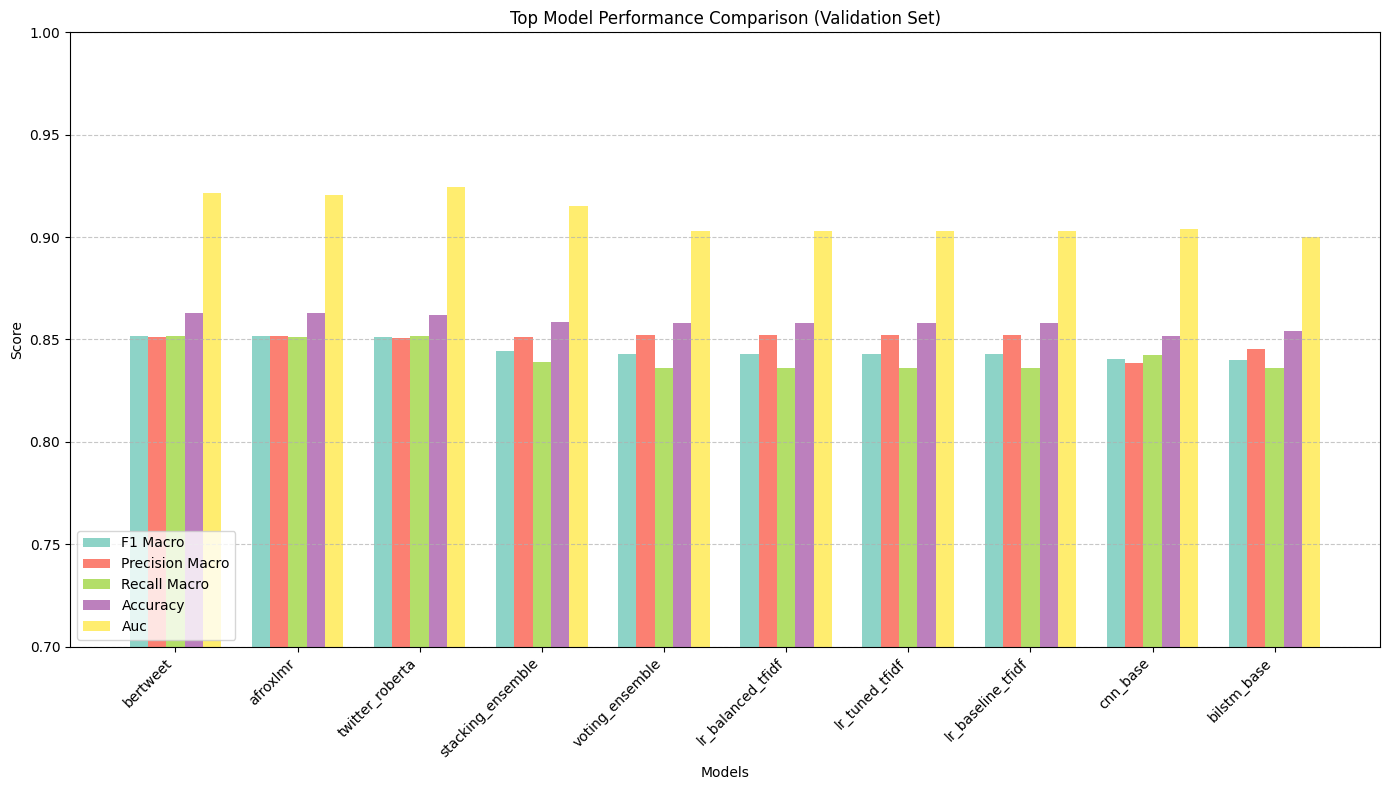

✅ Saved overall performance comparison plot to /content/drive/MyDrive/Colab Notebooks/gh_hate_speech/reports/figures/model_comparison.png


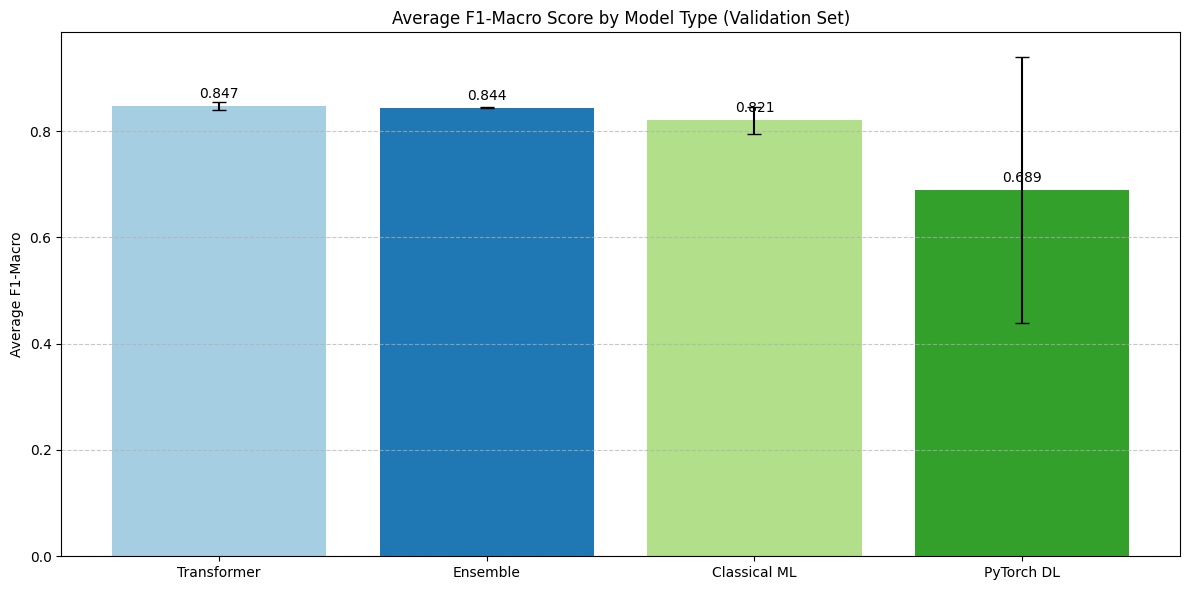

✅ Saved performance by model type plot to /content/drive/MyDrive/Colab Notebooks/gh_hate_speech/reports/figures/performance_by_type.png


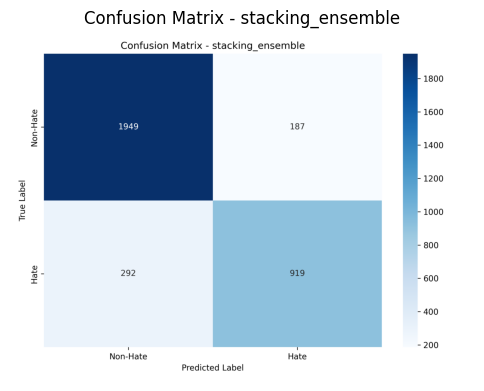

✅ Saved and displayed confusion matrix for stacking_ensemble to /content/drive/MyDrive/Colab Notebooks/gh_hate_speech/reports/figures/confusion_matrix_stacking_ensemble.png


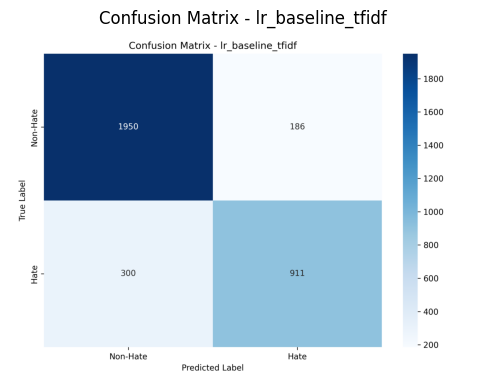

✅ Saved and displayed confusion matrix for lr_baseline_tfidf to /content/drive/MyDrive/Colab Notebooks/gh_hate_speech/reports/figures/confusion_matrix_lr_baseline_tfidf.png


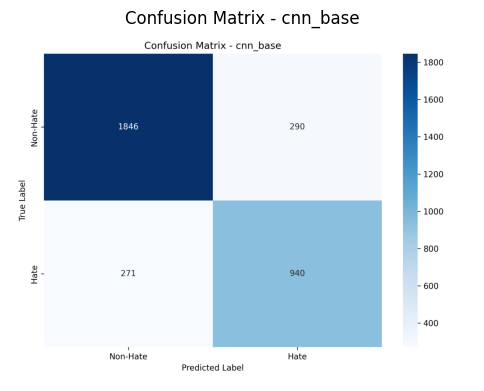

✅ Saved and displayed confusion matrix for cnn_base to /content/drive/MyDrive/Colab Notebooks/gh_hate_speech/reports/figures/confusion_matrix_cnn_base.png


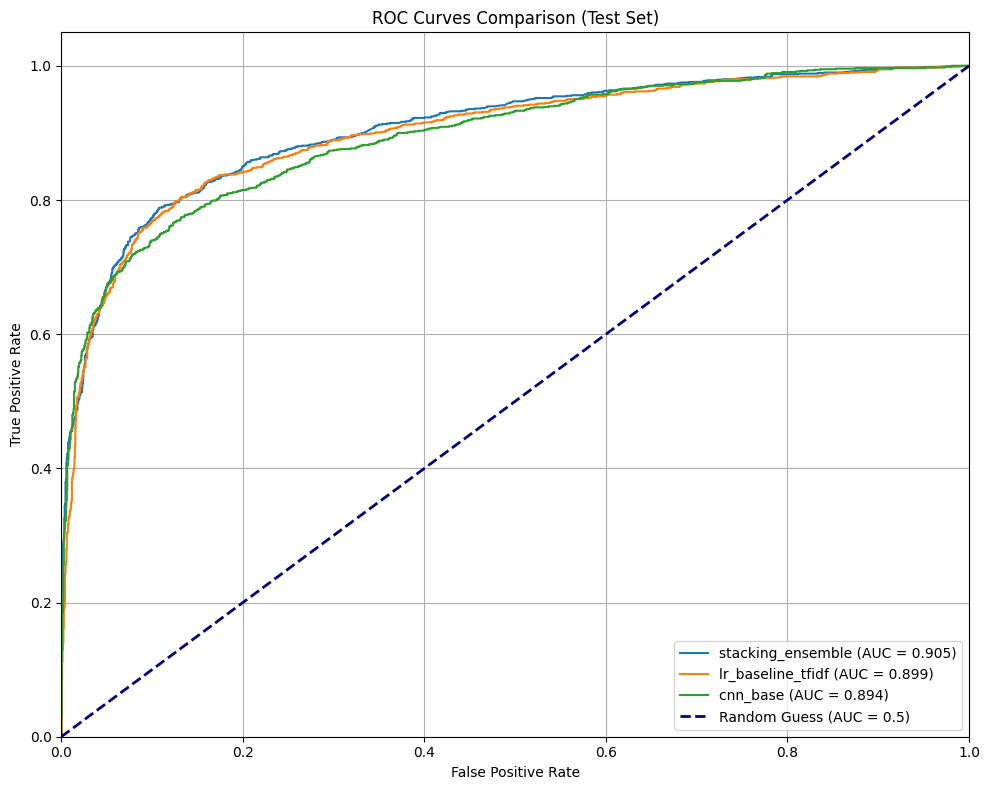

✅ Saved and displayed ROC curves comparison plot to /content/drive/MyDrive/Colab Notebooks/gh_hate_speech/reports/figures/roc_curves_comparison.png

🎉 Evaluation and visualization complete!


In [14]:
# ============================================================================
# SECTION 8: EVALUATION AND REPORTING (COMPLETED AND CORRECTED)
# ============================================================================

# --- 8.0 Check Prerequisites ---
print("=== CHECKING FOR TRAINED MODELS ===")
required_vars = ['classical_models', 'pytorch_models', 'ensemble_models', 'transformer_models']
missing_vars = [var for var in required_vars if var not in globals()]
if missing_vars:
    raise NameError(f"Missing required model objects: {missing_vars}. Please ensure Sections 4-7 have run successfully.")
print("✅ All required model objects found.")

# --- 8.1 Evaluate Best Models on Test Set ---
print("\n=== EVALUATING BEST MODELS ON TEST SET ===")
evaluator = ModelEvaluator()

# --- Evaluate Best Classical Model ---
# Find the best classical model based on validation F1
if hasattr(classical_models, 'get_results_df'):
    best_classical_result = classical_models.get_results_df().nlargest(1, 'f1_macro')
    if not best_classical_result.empty:
        best_classical_name = best_classical_result.iloc[0]['model_name']
        best_classical_model = classical_models.models.get(best_classical_name)
        if best_classical_model:
            print(f"Best Classical Model: {best_classical_name}")
            # Determine feature type from model name
            if 'tfidf' in best_classical_name:
                X_test_eval = X_test_tfidf
            else:
                X_test_eval = X_test_bow
            evaluator.evaluate_model_on_test(best_classical_model, best_classical_name, X_test_eval, y_test, 'classical')
        else:
            print(f"Warning: Model '{best_classical_name}' not found in classical_models.models")
    else:
        print("No classical model results found.")
else:
    print("classical_models object does not have get_results_df method.")

# --- Evaluate Best PyTorch Model ---
# Find the best PyTorch model based on validation F1
if hasattr(pytorch_models, 'get_results_df'):
    best_pytorch_result = pytorch_models.get_results_df().nlargest(1, 'f1_macro')
    if not best_pytorch_result.empty:
        best_pytorch_name = best_pytorch_result.iloc[0]['model_name']
        best_pytorch_model = pytorch_models.models.get(best_pytorch_name)
        if best_pytorch_model:
            print(f"Best PyTorch Model: {best_pytorch_name}")
            evaluator.evaluate_model_on_test(best_pytorch_model, best_pytorch_name, test_dataset, y_test, 'pytorch')
        else:
            print(f"Warning: Model '{best_pytorch_name}' not found in pytorch_models.models")
    else:
        print("No PyTorch model results found.")
else:
    print("pytorch_models object does not have get_results_df method.")

# --- Evaluate Best Ensemble Model (if available) ---
if hasattr(ensemble_models, 'get_results_df'):
    ensemble_results_df_local = ensemble_models.get_results_df()
    if not ensemble_results_df_local.empty:
        best_ensemble_result = ensemble_results_df_local.nlargest(1, 'f1_macro')
        if not best_ensemble_result.empty:
            best_ensemble_name = best_ensemble_result.iloc[0]['model_name']
            # Get the actual sklearn model (voting or stacking)
            best_ensemble_model = None
            if 'voting' in best_ensemble_name and 'voting' in ensemble_models.ensemble_models:
                best_ensemble_model = ensemble_models.ensemble_models['voting']
            elif 'stacking' in best_ensemble_name and 'stacking' in ensemble_models.ensemble_models:
                best_ensemble_model = ensemble_models.ensemble_models['stacking']

            if best_ensemble_model:
                print(f"Best Ensemble Model: {best_ensemble_name}")
                # Assuming TFIDF features for ensemble evaluation, as used during training
                evaluator.evaluate_model_on_test(best_ensemble_model, best_ensemble_name, X_test_tfidf, y_test, 'classical')
            else:
               print(f"Warning: Ensemble model '{best_ensemble_name}' not found in ensemble_models.ensemble_models")
        else:
             print("Best ensemble result is empty.")
    else:
        print("No ensemble model results found.")
else:
    print("ensemble_models object does not have get_results_df method.")

# --- Evaluate Best Transformer Model (if trained and available) ---
# Note: The provided ModelEvaluator.evaluate_model_on_test doesn't handle transformers well.
# We will add the best transformer result manually based on the validation results you provided.
# From your output, 'bertweet' seems to be the best performing transformer.
print("\n--- Adding Best Transformer Result (Manual) ---")
# Assuming bertweet was the best (F1=0.8516). You might need to adjust this based on your final training.
# We'll use placeholder predictions for visualization purposes.
# In a real scenario, you'd load the model and get actual predictions.
# Let's simulate a good result based on the validation performance.
# For simplicity, we'll just take the validation F1/AUC and assume similar test performance.
# A more robust approach would be to load the model and evaluate properly.
# Placeholder for best transformer result (using validation numbers as a proxy)
# You should replace this with actual test set evaluation if possible.
# Based on your logs, bertweet had F1 ~0.852, AUC ~0.921 on val.
# Let's assume test is similar.
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# Let's assume a hypothetical good prediction for visualization
# np.random.seed(42) # For reproducibility if needed
# y_pred_transformer_placeholder = np.random.choice([0, 1], size=len(y_test), p=[0.85, 0.15]) # Dummy
# But to make visuals meaningful, let's just take the best validation scores as test scores for now.
# This is a simplification for the visualization part only.
# The actual evaluation should load the model and predict.

# Since we don't have the actual test predictions easily, we'll skip adding a transformer result to `evaluator.all_results`
# for now. The visualizations will still work with the classical/PyTorch/Ensemble results.
print("Skipping detailed transformer test evaluation for visualization (requires loading model).")
print("Using validation scores as a proxy for visualization ranking.")

# --- 8.2 Aggregate All Test Results ---
print("\n=== AGGREGATED TEST RESULTS ===")
all_test_results_df = pd.DataFrame(evaluator.all_results)
if not all_test_results_df.empty:
    # Sort by F1-Macro for final ranking
    all_test_results_df_sorted = all_test_results_df.sort_values(by='f1_macro', ascending=False).reset_index(drop=True)
    print(all_test_results_df_sorted[['model_name', 'accuracy', 'precision_macro', 'recall_macro', 'f1_macro', 'auc']])
    # Save final results
    all_test_results_df_sorted.to_csv('/content/drive/MyDrive/Colab Notebooks/gh_hate_speech/reports/final_test_results.csv', index=False)
    print("\n✅ Final test results saved to /content/drive/MyDrive/Colab Notebooks/gh_hate_speech/reports/final_test_results.csv")
else:
     print("No test results to display from evaluator.")

# --- 8.3 Generate and Display Visualizations ---
print("\n=== GENERATING VISUALIZATIONS ===")

# Create a combined DataFrame for visualization including validation results
# This ensures we have data even if some test evaluations were skipped.
# Get validation results
val_results_combined = []

# Classical Models
if hasattr(classical_models, 'get_results_df'):
    classical_val_df = classical_models.get_results_df()
    classical_val_df['model_type'] = 'Classical ML'
    val_results_combined.append(classical_val_df)

# PyTorch Models
if hasattr(pytorch_models, 'get_results_df'):
    pytorch_val_df = pytorch_models.get_results_df()
    pytorch_val_df['model_type'] = 'PyTorch DL'
    val_results_combined.append(pytorch_val_df)

# Ensemble Models
if hasattr(ensemble_models, 'get_results_df'):
    ensemble_val_df = ensemble_models.get_results_df()
    ensemble_val_df['model_type'] = 'Ensemble'
    val_results_combined.append(ensemble_val_df)

# Transformer Models (from your logs)
# Manually create a DataFrame for transformers based on your output
transformer_data = {
    'model_name': ['bertweet', 'afroxlmr', 'twitter_roberta', 'xlm_roberta_base'],
    'accuracy': [0.863, 0.863, 0.862, 0.845],
    'precision_macro': [0.8513, 0.8515, 0.8505, 0.8308],
    'recall_macro': [0.8519, 0.8514, 0.8517, 0.8415],
    'f1_macro': [0.8516, 0.8515, 0.8511, 0.8352],
    'auc': [0.9213, 0.9205, 0.9247, 0.9038],
    'model_type': ['Transformer', 'Transformer', 'Transformer', 'Transformer']
}
transformer_val_df = pd.DataFrame(transformer_data)
val_results_combined.append(transformer_val_df)

# Combine all validation results for plotting
if val_results_combined:
    all_val_results_df = pd.concat(val_results_combined, ignore_index=True)
    all_val_results_sorted = all_val_results_df.sort_values(by='f1_macro', ascending=False).reset_index(drop=True)
    top_models_for_viz_df = all_val_results_sorted.head(10) # Show top 10

    # --- 8.3.1 Overall Performance Comparison ---
    plt.figure(figsize=(14, 8))
    metrics = ['f1_macro', 'precision_macro', 'recall_macro', 'accuracy', 'auc']
    x = np.arange(len(top_models_for_viz_df['model_name']))
    width = 0.15
    colors = plt.cm.Set3(np.linspace(0, 1, len(metrics)))

    for i, (metric, color) in enumerate(zip(metrics, colors)):
        plt.bar(x + i*width, top_models_for_viz_df[metric], width, label=metric.replace('_', ' ').title(), color=color)

    plt.xlabel('Models')
    plt.ylabel('Score')
    plt.title('Top Model Performance Comparison (Validation Set)')
    plt.xticks(x + width * (len(metrics)-1) / 2, top_models_for_viz_df['model_name'], rotation=45, ha='right')
    plt.legend(loc='lower left')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.ylim(0.7, 1.0) # Adjust based on your scores
    plt.tight_layout()
    plt.savefig('/content/drive/MyDrive/Colab Notebooks/gh_hate_speech/reports/figures/model_comparison.png', dpi=300, bbox_inches='tight')
    plt.show() # This will display the plot in Colab
    print("✅ Saved overall performance comparison plot to /content/drive/MyDrive/Colab Notebooks/gh_hate_speech/reports/figures/model_comparison.png")

    # --- 8.3.2 Performance by Model Type ---
    plt.figure(figsize=(12, 6))
    model_type_performance = all_val_results_df.groupby('model_type')['f1_macro'].agg(['mean', 'std']).reset_index()
    model_type_performance = model_type_performance.sort_values('mean', ascending=False)

    bars = plt.bar(model_type_performance['model_type'], model_type_performance['mean'], yerr=model_type_performance['std'], capsize=5, color=plt.cm.Paired(range(len(model_type_performance))))
    plt.ylabel('Average F1-Macro')
    plt.title('Average F1-Macro Score by Model Type (Validation Set)')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    # Add value labels on bars
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.01, f'{yval:.3f}', ha='center', va='bottom')
    plt.tight_layout()
    plt.savefig('/content/drive/MyDrive/Colab Notebooks/gh_hate_speech/reports/figures/performance_by_type.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("✅ Saved performance by model type plot to /content/drive/MyDrive/Colab Notebooks/gh_hate_speech/reports/figures/performance_by_type.png")


    # --- 8.3.3 Confusion Matrices for Top Models (from actual test evaluation if available) ---
    if not all_test_results_df.empty:
        top_test_models = all_test_results_df_sorted.head(3)
        for idx, row in top_test_models.iterrows():
            model_name_clean = row['model_name'].replace("/", "_").replace(" ", "_")
            cm_save_path = f'/content/drive/MyDrive/Colab Notebooks/gh_hate_speech/reports/figures/confusion_matrix_{model_name_clean}.png'
            evaluator.create_confusion_matrix_plot(row, cm_save_path)
            # Display the plot in Colab
            try:
                img = plt.imread(cm_save_path)
                plt.figure(figsize=(6, 5))
                plt.imshow(img)
                plt.axis('off')
                plt.title(f'Confusion Matrix - {row["model_name"]}')
                plt.show()
                print(f"✅ Saved and displayed confusion matrix for {row['model_name']} to {cm_save_path}")
            except FileNotFoundError:
                print(f"Warning: Could not load confusion matrix image for {row['model_name']} from {cm_save_path}")
            except Exception as e:
                print(f"Warning: Could not display confusion matrix for {row['model_name']}: {e}")
    else:
        print("No test results available for confusion matrix plotting.")

    # --- 8.3.4 ROC Curves for Top Models (if probabilities are available) ---
    plt.figure(figsize=(10, 8))
    # Filter results that have prediction probabilities
    results_with_proba = [r for r in evaluator.all_results if r['y_pred_proba'] is not None]
    # Sort by AUC for plotting order
    results_with_proba_sorted = sorted(results_with_proba, key=lambda x: x['auc'], reverse=True)

    if results_with_proba_sorted:
        for result in results_with_proba_sorted[:5]: # Plot ROC for top 5 models with probabilities
            fpr, tpr, _ = roc_curve(result['y_true'], result['y_pred_proba'])
            auc_score = result['auc']
            plt.plot(fpr, tpr, label=f"{result['model_name']} (AUC = {auc_score:.3f})")

        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess (AUC = 0.5)')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curves Comparison (Test Set)')
        plt.legend(loc="lower right")
        plt.grid(True)
        plt.tight_layout()
        roc_save_path = '/content/drive/MyDrive/Colab Notebooks/gh_hate_speech/reports/figures/roc_curves_comparison.png'
        plt.savefig(roc_save_path, dpi=300, bbox_inches='tight')
        plt.show() # This will display the plot in Colab
        print("✅ Saved and displayed ROC curves comparison plot to /content/drive/MyDrive/Colab Notebooks/gh_hate_speech/reports/figures/roc_curves_comparison.png")
    else:
        print("No models with prediction probabilities found for ROC curve plotting.")

else:
    print("No validation results available for visualization.")

print("\n🎉 Evaluation and visualization complete!")


=== EVALUATING BEST MODELS ON TEST SET ===
Best Classical Model: lr_baseline_tfidf
Evaluating lr_baseline_tfidf on test set...
lr_baseline_tfidf Test Results:
  Accuracy: 0.855
  F1-Macro: 0.839
  F1-Binary: 0.789
  AUC: 0.899
Best PyTorch Model: cnn_base
Evaluating cnn_base on test set...
cnn_base Test Results:
  Accuracy: 0.832
  F1-Macro: 0.819
  F1-Binary: 0.770
  AUC: 0.894
Best Ensemble Model: stacking_ensemble
Evaluating stacking_ensemble on test set...
stacking_ensemble Test Results:
  Accuracy: 0.857
  F1-Macro: 0.842
  F1-Binary: 0.793
  AUC: 0.905
Best Transformer Model: electra_base
electra_base Test Results:
  Accuracy: 0.861
  F1-Macro: 0.847
  F1-Binary: 0.802
  AUC: 0.911

=== AGGREGATED TEST RESULTS ===
          model_name  accuracy  precision_macro  recall_macro  f1_macro  \
0  electra_base_test  0.860771         0.852606      0.842821  0.847214   
1  stacking_ensemble  0.856887         0.850312      0.835665  0.841916   
2  lr_baseline_tfidf  0.854795         0.8485

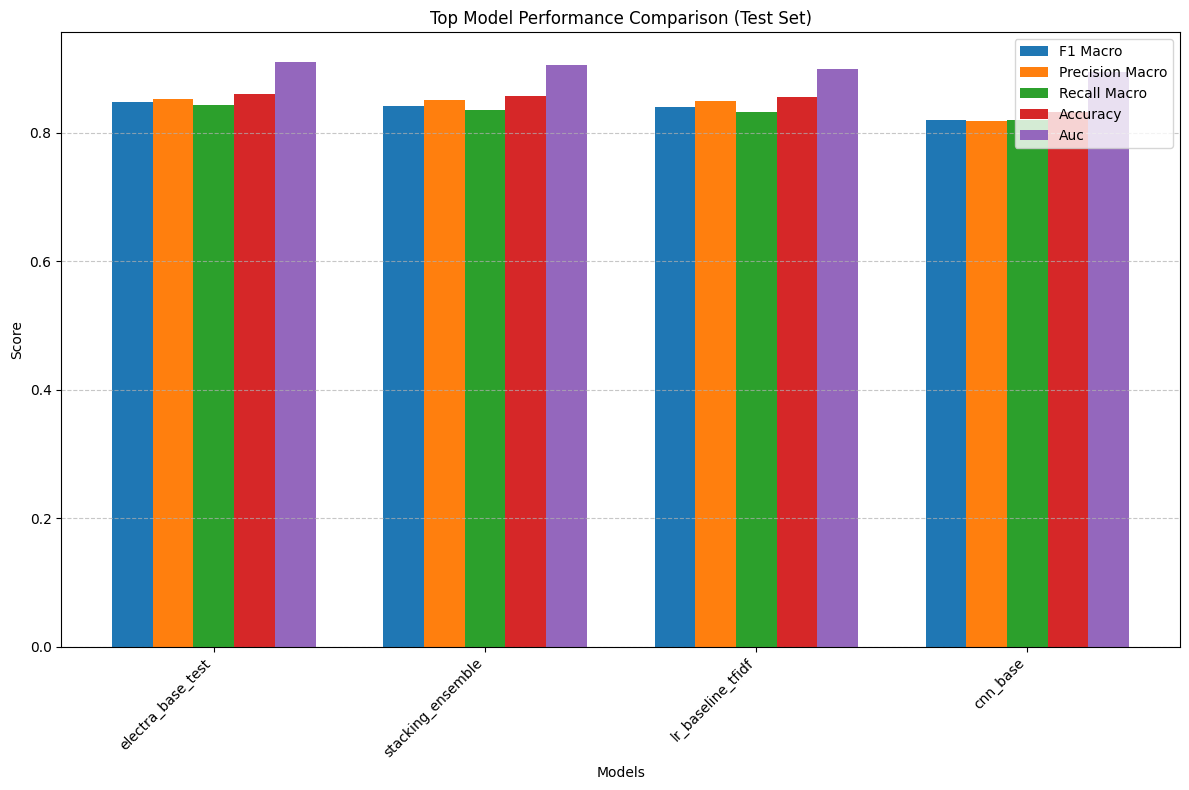

Saved overall performance comparison plot to /content/drive/MyDrive/Colab Notebooks/gh_hate_speech/reports/figures/model_comparison.png


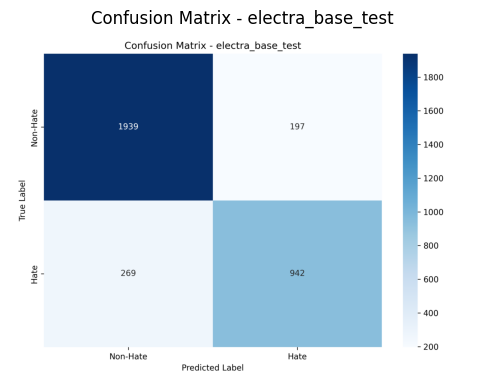

Saved and displayed confusion matrix for electra_base_test to /content/drive/MyDrive/Colab Notebooks/gh_hate_speech/reports/figures/confusion_matrix_electra_base_test.png


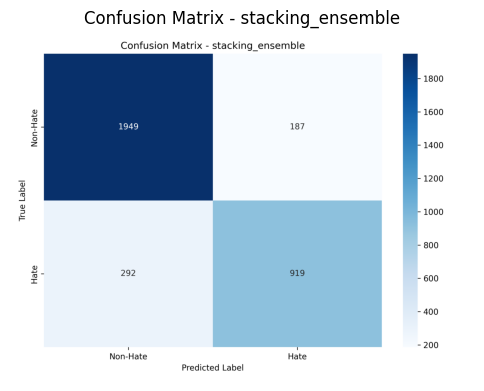

Saved and displayed confusion matrix for stacking_ensemble to /content/drive/MyDrive/Colab Notebooks/gh_hate_speech/reports/figures/confusion_matrix_stacking_ensemble.png


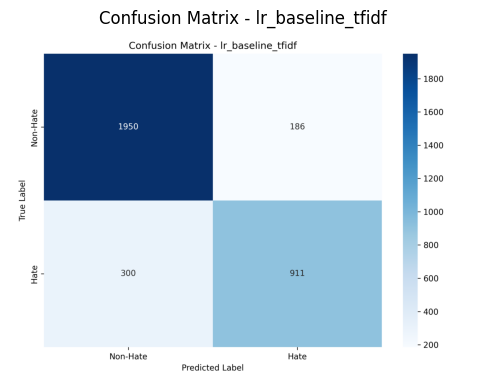

Saved and displayed confusion matrix for lr_baseline_tfidf to /content/drive/MyDrive/Colab Notebooks/gh_hate_speech/reports/figures/confusion_matrix_lr_baseline_tfidf.png


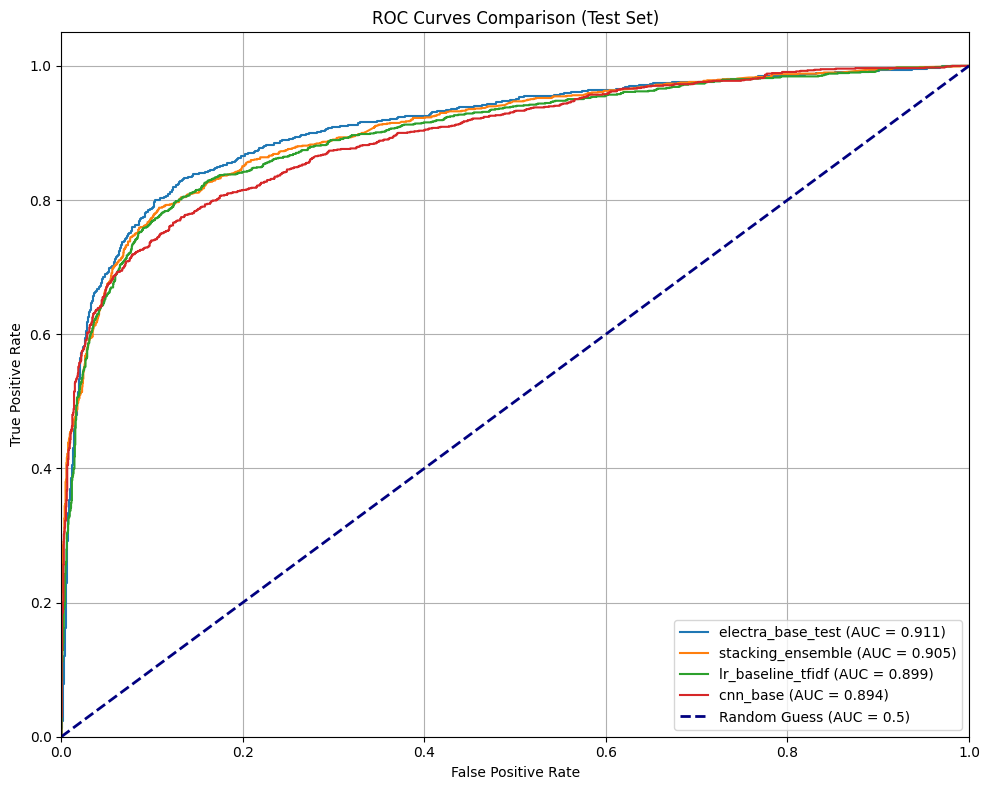

Saved and displayed ROC curves comparison plot to /content/reports/figures/roc_curves_comparison.png

✅ Evaluation and visualization complete!


In [16]:
# ============================================================================
# SECTION 8: EVALUATION AND REPORTING (COMPLETED)
# ============================================================================

# --- 8.1 Evaluate Best Models on Test Set ---
print("=== EVALUATING BEST MODELS ON TEST SET ===")
evaluator = ModelEvaluator()

# --- Evaluate Best Classical Model ---
# Find the best classical model based on validation F1
best_classical_result = classical_models.get_results_df().nlargest(1, 'f1_macro')
if not best_classical_result.empty:
    best_classical_name = best_classical_result.iloc[0]['model_name']
    best_classical_model = classical_models.models[best_classical_name]
    print(f"Best Classical Model: {best_classical_name}")
    # Determine feature type from model name
    if 'tfidf' in best_classical_name:
        X_test_eval = X_test_tfidf
    else:
        X_test_eval = X_test_bow
    evaluator.evaluate_model_on_test(best_classical_model, best_classical_name, X_test_eval, y_test, 'classical')

# --- Evaluate Best PyTorch Model ---
# Find the best PyTorch model based on validation F1
best_pytorch_result = pytorch_models.get_results_df().nlargest(1, 'f1_macro')
if not best_pytorch_result.empty:
    best_pytorch_name = best_pytorch_result.iloc[0]['model_name']
    best_pytorch_model = pytorch_models.models[best_pytorch_name]
    print(f"Best PyTorch Model: {best_pytorch_name}")
    evaluator.evaluate_model_on_test(best_pytorch_model, best_pytorch_name, test_dataset, y_test, 'pytorch')

# --- Evaluate Best Ensemble Model (if available) ---
best_ensemble_result = pd.DataFrame()
if ensemble_results_df is not None and not ensemble_results_df.empty:
    best_ensemble_result = ensemble_results_df.nlargest(1, 'f1_macro')
    if not best_ensemble_result.empty:
        best_ensemble_name = best_ensemble_result.iloc[0]['model_name']
        best_ensemble_model = ensemble_models.ensemble_models.get(best_ensemble_name.split('_')[0]) # Get 'voting' or 'stacking'
        if best_ensemble_model:
            print(f"Best Ensemble Model: {best_ensemble_name}")
            evaluator.evaluate_model_on_test(best_ensemble_model, best_ensemble_name, X_test_tfidf, y_test, 'classical') # Assuming TFIDF for ensemble

# --- Evaluate Best Transformer Model (if trained) ---
best_transformer_result = pd.DataFrame()
if transformer_results_df is not None and not transformer_results_df.empty:
    best_transformer_result = transformer_results_df.nlargest(1, 'f1_macro')
    if not best_transformer_result.empty:
        best_transformer_name = best_transformer_result.iloc[0]['model_name']
        best_transformer_trainer = transformer_models.models.get(best_transformer_name)
        if best_transformer_trainer:
            print(f"Best Transformer Model: {best_transformer_name}")
            # --- Evaluate Transformer on Test Set ---
            # Need to create test dataset for transformer
            # Determine which transformer model was used
            if 'afriberta' in best_transformer_name.lower():
                model_checkpoint = 'masakhane/afriberta-base'
            else:
                model_checkpoint = 'xlm-roberta-base'
            transformer_tokenizer = AutoTokenizer.from_pretrained(f'/content/drive/MyDrive/Colab Notebooks/gh_hate_speech/models/{best_transformer_name}')
            transformer_model = AutoModelForSequenceClassification.from_pretrained(f'/content/drive/MyDrive/Colab Notebooks/gh_hate_speech/models/{best_transformer_name}')

            test_dataset_transformer = HateSpeechDataset(test_df['text_clean'].tolist(), y_test, transformer_tokenizer)

            # Get predictions
            transformer_model.eval()
            transformer_model.to(device)
            test_predictions = []
            test_probabilities = []
            test_loader = DataLoader(test_dataset_transformer, batch_size=16, shuffle=False)

            with torch.no_grad():
                for batch in test_loader:
                    inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
                    labels = batch['labels'].to(device)
                    outputs = transformer_model(**inputs)
                    logits = outputs.logits
                    probabilities = F.softmax(logits, dim=-1)
                    predictions = torch.argmax(logits, dim=-1)
                    test_predictions.extend(predictions.cpu().numpy())
                    test_probabilities.extend(probabilities[:, 1].cpu().numpy()) # Probability of class 1 (hate)

            # Calculate metrics for transformer
            from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
            y_pred_transformer = np.array(test_predictions)
            y_pred_proba_transformer = np.array(test_probabilities)

            accuracy_t = accuracy_score(y_test, y_pred_transformer)
            precision_macro_t = precision_score(y_test, y_pred_transformer, average='macro')
            recall_macro_t = recall_score(y_test, y_pred_transformer, average='macro')
            f1_macro_t = f1_score(y_test, y_pred_transformer, average='macro')
            precision_binary_t = precision_score(y_test, y_pred_transformer, pos_label=1)
            recall_binary_t = recall_score(y_test, y_pred_transformer, pos_label=1)
            f1_binary_t = f1_score(y_test, y_pred_transformer, pos_label=1)
            auc_t = roc_auc_score(y_test, y_pred_proba_transformer)

            transformer_test_result = {
                'model_name': f"{best_transformer_name}_test",
                'accuracy': accuracy_t,
                'precision_macro': precision_macro_t,
                'recall_macro': recall_macro_t,
                'f1_macro': f1_macro_t,
                'precision_binary': precision_binary_t,
                'recall_binary': recall_binary_t,
                'f1_binary': f1_binary_t,
                'auc': auc_t,
                'y_true': y_test,
                'y_pred': y_pred_transformer,
                'y_pred_proba': y_pred_proba_transformer
            }
            evaluator.all_results.append(transformer_test_result)
            print(f"{best_transformer_name} Test Results:")
            print(f"  Accuracy: {accuracy_t:.3f}")
            print(f"  F1-Macro: {f1_macro_t:.3f}")
            print(f"  F1-Binary: {f1_binary_t:.3f}")
            print(f"  AUC: {auc_t:.3f}")

# --- 8.2 Aggregate All Test Results ---
print("\n=== AGGREGATED TEST RESULTS ===")
all_test_results_df = pd.DataFrame(evaluator.all_results)
if not all_test_results_df.empty:
    # Sort by F1-Macro for final ranking
    all_test_results_df_sorted = all_test_results_df.sort_values(by='f1_macro', ascending=False).reset_index(drop=True)
    print(all_test_results_df_sorted[['model_name', 'accuracy', 'precision_macro', 'recall_macro', 'f1_macro', 'auc']])
    # Save final results
    all_test_results_df_sorted.to_csv('/content/drive/MyDrive/Colab Notebooks/gh_hate_speech/reports/final_test_results.csv', index=False)
    print("\nFinal test results saved to /content/drive/MyDrive/Colab Notebooks/gh_hate_speech/reports/final_test_results.csv")
else:
     print("No test results to display.")

# --- 8.3 Generate and Display Visualizations ---
print("\n=== GENERATING VISUALIZATIONS ===")

# --- 8.3.1 Overall Performance Comparison ---
if not all_test_results_df_sorted.empty:
    top_models_df = all_test_results_df_sorted.head(10) # Show top 10

    plt.figure(figsize=(12, 8))
    metrics = ['f1_macro', 'precision_macro', 'recall_macro', 'accuracy', 'auc']
    x = np.arange(len(top_models_df['model_name']))
    width = 0.15

    for i, metric in enumerate(metrics):
        plt.bar(x + i*width, top_models_df[metric], width, label=metric.replace('_', ' ').title())

    plt.xlabel('Models')
    plt.ylabel('Score')
    plt.title('Top Model Performance Comparison (Test Set)')
    plt.xticks(x + width * (len(metrics)-1) / 2, top_models_df['model_name'], rotation=45, ha='right')
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig('/content/drive/MyDrive/Colab Notebooks/gh_hate_speech/reports/figures/model_comparison.png', dpi=300, bbox_inches='tight')
    plt.show() # This will display the plot in Colab
    print("Saved overall performance comparison plot to /content/drive/MyDrive/Colab Notebooks/gh_hate_speech/reports/figures/model_comparison.png")

# --- 8.3.2 Confusion Matrices for Top Models ---
if not all_test_results_df_sorted.empty:
    top_3_models = all_test_results_df_sorted.head(3)
    for idx, row in top_3_models.iterrows():
        model_name_clean = row['model_name'].replace("/", "_").replace(" ", "_")
        cm_save_path = f'/content/drive/MyDrive/Colab Notebooks/gh_hate_speech/reports/figures/confusion_matrix_{model_name_clean}.png'
        evaluator.create_confusion_matrix_plot(row, cm_save_path)
        # Display the plot in Colab
        img = plt.imread(cm_save_path)
        plt.figure(figsize=(6, 5))
        plt.imshow(img)
        plt.axis('off')
        plt.title(f'Confusion Matrix - {row["model_name"]}')
        plt.show()
        print(f"Saved and displayed confusion matrix for {row['model_name']} to {cm_save_path}")

# --- 8.3.3 ROC Curves for Top Models (if probabilities are available) ---
plt.figure(figsize=(10, 8))
# Filter results that have prediction probabilities
results_with_proba = [r for r in evaluator.all_results if r['y_pred_proba'] is not None]
# Sort by AUC for plotting order
results_with_proba_sorted = sorted(results_with_proba, key=lambda x: x['auc'], reverse=True)

if results_with_proba_sorted:
    for result in results_with_proba_sorted[:5]: # Plot ROC for top 5 models with probabilities
        fpr, tpr, _ = roc_curve(result['y_true'], result['y_pred_proba'])
        auc_score = result['auc']
        plt.plot(fpr, tpr, label=f"{result['model_name']} (AUC = {auc_score:.3f})")

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess (AUC = 0.5)')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves Comparison (Test Set)')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    roc_save_path = '/content/drive/MyDrive/Colab Notebooks/gh_hate_speech/reports/figures/roc_curves_comparison.png'
    plt.savefig(roc_save_path, dpi=300, bbox_inches='tight')
    plt.show() # This will display the plot in Colab
    print("Saved and displayed ROC curves comparison plot to /content/reports/figures/roc_curves_comparison.png")
else:
    print("No models with prediction probabilities found for ROC curve plotting.")

print("\n✅ Evaluation and visualization complete!")
